<a href="https://colab.research.google.com/github/MatthewSebastian15/Automated-Portfolio-Management/blob/main/4_Big_Banks_Stocks/Main_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated Portfolio Management**
## **(BBCA, BBRI, BMRI, BBNI)**

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from scipy.optimize import minimize
from datetime import datetime, timedelta

In [2]:
TICKERS = ['BBCA.JK', 'BMRI.JK', 'BBRI.JK', 'BBNI.JK']
START_DATE = '2006-01-01'
END_DATE = '2025-12-31'

LOOKBACK_WINDOW = 20
FORWARD_DAYS = 5
ROLLING_SCALER_DAYS = 252
REBALANCE_THRESHOLD = 0.10
WEIGHT_SMOOTH_ALPHA = 0.4
TRADING_COST_BPS = 0.0005
MV_LOOKBACK_DAYS = 252

In [3]:
# Load data
def load_data(tickers, start, end):
    raw_data = yf.download(tickers, start=start, end=end, auto_adjust=True)
    prices = raw_data['Close'].ffill().bfill()
    volume = raw_data['Volume'].ffill().bfill()
    log_returns = np.log(prices / prices.shift(1)).dropna()
    volume_pct_change = volume.pct_change().replace([np.inf, -np.inf], 0).fillna(0)
    return prices, log_returns, volume, volume_pct_change

prices, log_returns, volume, df_volume_pct_change = load_data(TICKERS, START_DATE, END_DATE)

[*********************100%***********************]  4 of 4 completed


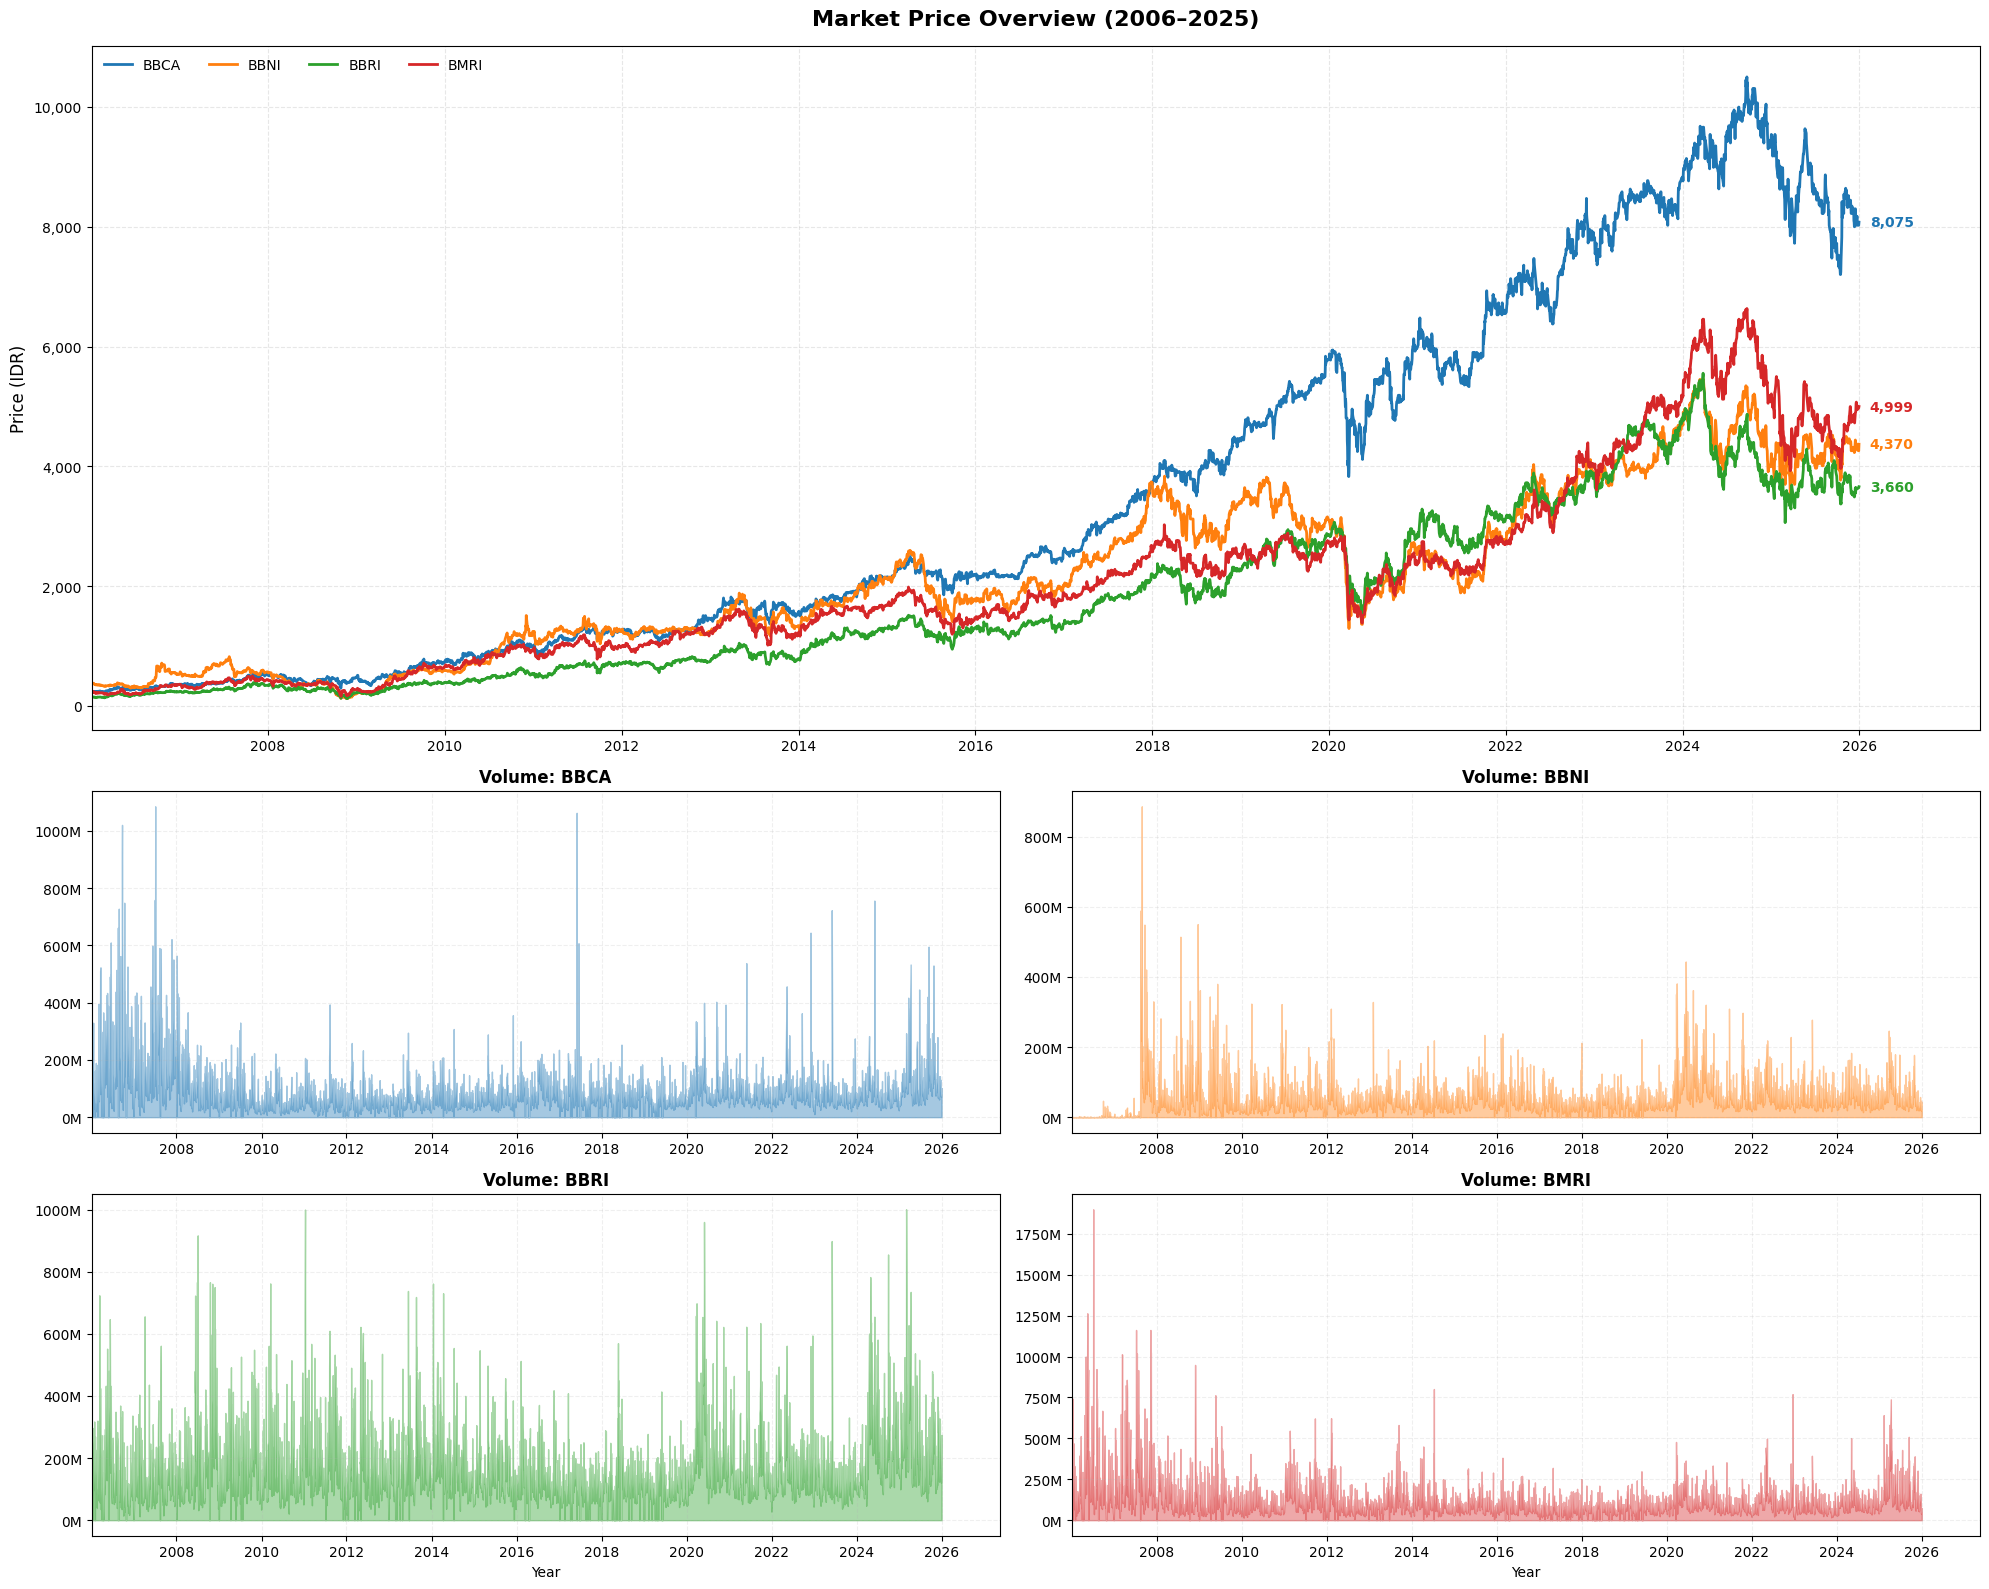

In [4]:
data_market = prices.loc['2006-01-01':'2025-12-31'].copy()
data_volume = volume.loc['2006-01-01':'2025-12-31'].copy()
data_market.columns = data_market.columns.str.replace('.JK', '', regex=False)
data_volume.columns = data_volume.columns.str.replace('.JK', '', regex=False)
tickers_clean = data_market.columns
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(3, 2, height_ratios=[2, 1, 1])
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

ax_price = fig.add_subplot(gs[0, :])
for col, color in zip(tickers_clean, colors):
    ax_price.plot(data_market.index, data_market[col], label=col, linewidth=2, color=color)
    ax_price.text(data_market.index[-1] + pd.Timedelta(days=45), data_market[col].iloc[-1], f"{data_market[col].iloc[-1]:,.0f}", fontsize=10, fontweight='bold', color=color, va='center')

ax_price.set_title("Market Price Overview (2006–2025)", fontsize=16, fontweight='bold', pad=15)
ax_price.set_ylabel("Price (IDR)", fontsize=12)
ax_price.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
ax_price.grid(True, linestyle='--', alpha=0.3)
ax_price.legend(loc='upper left', frameon=False, ncol=4)

for i, (col, color) in enumerate(zip(tickers_clean, colors)):
    row = (i // 2) + 1
    c = i % 2
    ax_vol = fig.add_subplot(gs[row, c], sharex=ax_price)
    ax_vol.fill_between(data_volume.index, data_volume[col], color=color, alpha=0.4)
    ax_vol.set_title(f"Volume: {col}", fontsize=12, fontweight='bold')
    ax_vol.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
    ax_vol.grid(True, linestyle='--', alpha=0.2)

    if row == 2:
        ax_vol.set_xlabel("Year")

ax_price.xaxis.set_major_locator(mdates.YearLocator(2))
ax_price.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(data_market.index[0], data_market.index[-1] + pd.Timedelta(days=500))
plt.tight_layout()
plt.show()

In [5]:
# FEATURE ENGINEERING
def create_features(df_returns, df_volume_change):
    feats = []
    idx = df_returns.index.intersection(df_volume_change.index)
    df_returns = df_returns.loc[idx]
    df_volume_change = df_volume_change.loc[idx]

    for t in df_returns.columns:
        ret_features = pd.concat([
            df_returns[t].rename(f"{t}_ret"),
            df_returns[t].rolling(20).std().rename(f"{t}_vol"),
            df_returns[t].rolling(20).mean().rename(f"{t}_mom1m"),
            df_returns[t].rolling(60).mean().rename(f"{t}_mom3m"),
            df_returns[t].rolling(120).mean().rename(f"{t}_mom6m"),
            (df_returns[t].rolling(20).mean() - df_returns[t].rolling(60).mean()).rename(f"{t}_accel"),
        ], axis=1)

        vol_features = pd.concat([
            df_volume_change[t].rename(f"{t}_vol_chg"),
            df_volume_change[t].rolling(20).mean().rename(f"{t}_vol_ma20"),
            df_volume_change[t].rolling(60).mean().rename(f"{t}_vol_ma60"),
            df_volume_change[t].rolling(20).std().rename(f"{t}_vol_std"),
        ], axis=1)

        feats.append(pd.concat([ret_features, vol_features], axis=1))

    X = pd.concat(feats, axis=1).dropna()
    y = df_returns.loc[X.index]
    return X, y

X_raw, y_raw = create_features(log_returns, df_volume_pct_change)


# SEQUENCES
def get_sequences_forward(X, y, window, fwd):
    Xs, ys = [], []
    for i in range(len(X) - window - fwd):
        Xs.append(X.iloc[i:i+window].values)
        ys.append(y.iloc[i+window:i+window+fwd].sum().values)
    return np.array(Xs), np.array(ys)


# LOSS FUNCTION
def turnover_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    turnover = tf.reduce_mean(tf.abs(y_pred[:,1:] - y_pred[:,:-1]))
    max_weight = tf.reduce_max(y_pred, axis=-1)
    entropy = -tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-8), axis=-1)
    return mse + 0.005 * turnover - 0.02 * tf.reduce_mean(max_weight) + 0.01 * tf.reduce_mean(entropy)


# MEAN VARIANCE
def get_mean_variance_weights(returns):
    if returns.empty:
        return np.ones(len(TICKERS)) / len(TICKERS)

    mu = returns.mean() * 252
    sigma = returns.cov() * 252
    n = len(mu)

    def neg_sharpe(w):
        r = np.dot(mu, w)
        v = np.sqrt(w.T @ sigma @ w) + 1e-8
        return -r / v

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * n
    init = np.ones(n) / n

    try:
        res = minimize(neg_sharpe, init, bounds=bounds, constraints=cons)
        return res.x if res.success else init
    except:
        return init


# MODEL
def build_model(input_shape, n_assets):
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(256, return_sequences=True)(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dense(64, activation='swish')(x)
    x = layers.Dense(32, activation='swish')(x)
    out = layers.Dense(n_assets, activation='softmax')(x)
    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0003),loss=turnover_loss)
    return model

In [6]:
years = sorted(X_raw.index.year.unique())
test_years = [y for y in years if y > 2015]

portfolio_values = {'Model': [], 'EqualWeight': [], 'MeanVariance': []}
dates_history = []
weights_history = []
mv_weights_history = []

current_capital = ew_capital = mv_capital = 1.0
current_weights = ew_weights = mv_weights = np.ones(len(TICKERS)) / len(TICKERS)
prev_model_weights = None

for year in test_years:
    tf.keras.backend.clear_session()

    print(f"Processing Year: {year}")

    train_mask = X_raw.index.year < year
    test_mask = X_raw.index.year == year
    X_train = X_raw[train_mask]
    y_train = y_raw[train_mask]
    X_test = X_raw[test_mask]
    y_test = y_raw[test_mask]
    scaler_window = X_train.tail(ROLLING_SCALER_DAYS)
    mean_tr = scaler_window.mean()
    std_tr = scaler_window.std()
    X_train_s = (X_train - mean_tr) / (std_tr + 1e-8)
    X_test_s = (X_test - mean_tr) / (std_tr + 1e-8)
    X_train_seq, y_train_seq = get_sequences_forward(X_train_s, y_train, LOOKBACK_WINDOW, FORWARD_DAYS)
    model = build_model((LOOKBACK_WINDOW, X_raw.shape[1]), len(TICKERS))

    if prev_model_weights is not None:
        model.set_weights(prev_model_weights)

    model.fit(
        X_train_seq,
        y_train_seq,
        epochs=100,
        batch_size=32,
        verbose=0,
        callbacks=[
            callbacks.EarlyStopping(monitor='loss',patience=8,restore_best_weights=True),
            callbacks.ReduceLROnPlateau(monitor='loss',factor=0.5,patience=3,min_lr=1e-6)
        ]
    )

    prev_model_weights = model.get_weights()
    X_test_seq, _ = get_sequences_forward(X_test_s, y_test, LOOKBACK_WINDOW, FORWARD_DAYS)
    preds = model.predict(X_test_seq, verbose=0) if len(X_test_seq) > 0 else []

    for i, date in enumerate(y_test.index):
        if i < LOOKBACK_WINDOW + FORWARD_DAYS:
            portfolio_values['Model'].append(current_capital)
            portfolio_values['EqualWeight'].append(ew_capital)
            portfolio_values['MeanVariance'].append(mv_capital)
            dates_history.append(date)
            weights_history.append(current_weights.copy())
            mv_weights_history.append(mv_weights.copy())
            continue

        daily_ret = np.exp(y_test.iloc[i].values) - 1
        pred_idx = i - LOOKBACK_WINDOW - FORWARD_DAYS
        raw_w = preds[pred_idx] if pred_idx < len(preds) else current_weights
        top_idx = np.argmax(raw_w)
        raw_w = raw_w ** 3.5
        raw_w /= raw_w.sum()

        if raw_w[top_idx] > 0.40:
            excess = raw_w[top_idx] - 0.40
            raw_w[top_idx] = 0.40
            others = [j for j in range(len(raw_w)) if j != top_idx]
            raw_w[others] += excess / len(others)

        vol_change = df_volume_pct_change.loc[date]
        if vol_change[TICKERS[top_idx]] < 0:
            raw_w = 0.7 * current_weights + 0.3 * raw_w
            raw_w /= raw_w.sum()

        confidence = raw_w[top_idx]
        aggressive_alpha = 0.85 if confidence > 0.30 else 0.7 if confidence > 0.20 else 0.5
        dynamic_threshold = 0.05 if confidence > 0.30 else REBALANCE_THRESHOLD

        weight_change = np.sum(np.abs(raw_w - current_weights))

        if weight_change > dynamic_threshold:
            target_w = (1 - aggressive_alpha) * current_weights + aggressive_alpha * raw_w
            target_w /= target_w.sum()
            turnover = np.sum(np.abs(target_w - current_weights))
            current_capital *= (1 - turnover * TRADING_COST_BPS)
            current_weights = target_w

            mv_hist = y_raw.loc[y_raw.index < date].tail(MV_LOOKBACK_DAYS)
            mv_target = get_mean_variance_weights(mv_hist)
            mv_turn = np.sum(np.abs(mv_target - mv_weights))
            mv_capital *= (1 - mv_turn * TRADING_COST_BPS)
            mv_weights = mv_target

        current_capital *= (1 + np.dot(current_weights, daily_ret))
        ew_capital *= (1 + np.dot(ew_weights, daily_ret))
        mv_capital *= (1 + np.dot(mv_weights, daily_ret))

        current_weights = (current_weights * (1 + daily_ret))
        current_weights /= current_weights.sum()

        ew_weights = (ew_weights * (1 + daily_ret))
        ew_weights /= ew_weights.sum()

        mv_weights = (mv_weights * (1 + daily_ret))
        mv_weights /= mv_weights.sum()

        portfolio_values['Model'].append(current_capital)
        portfolio_values['EqualWeight'].append(ew_capital)
        portfolio_values['MeanVariance'].append(mv_capital)
        dates_history.append(date)
        weights_history.append(current_weights.copy())
        mv_weights_history.append(mv_weights.copy())

Processing Year: 2016
Processing Year: 2017
Processing Year: 2018


Processing Year: 2019


Processing Year: 2020
Processing Year: 2021
Processing Year: 2022
Processing Year: 2023
Processing Year: 2024
Processing Year: 2025


# **(Actual Data 2016 - 2025)**

## **Cumulative Returns**

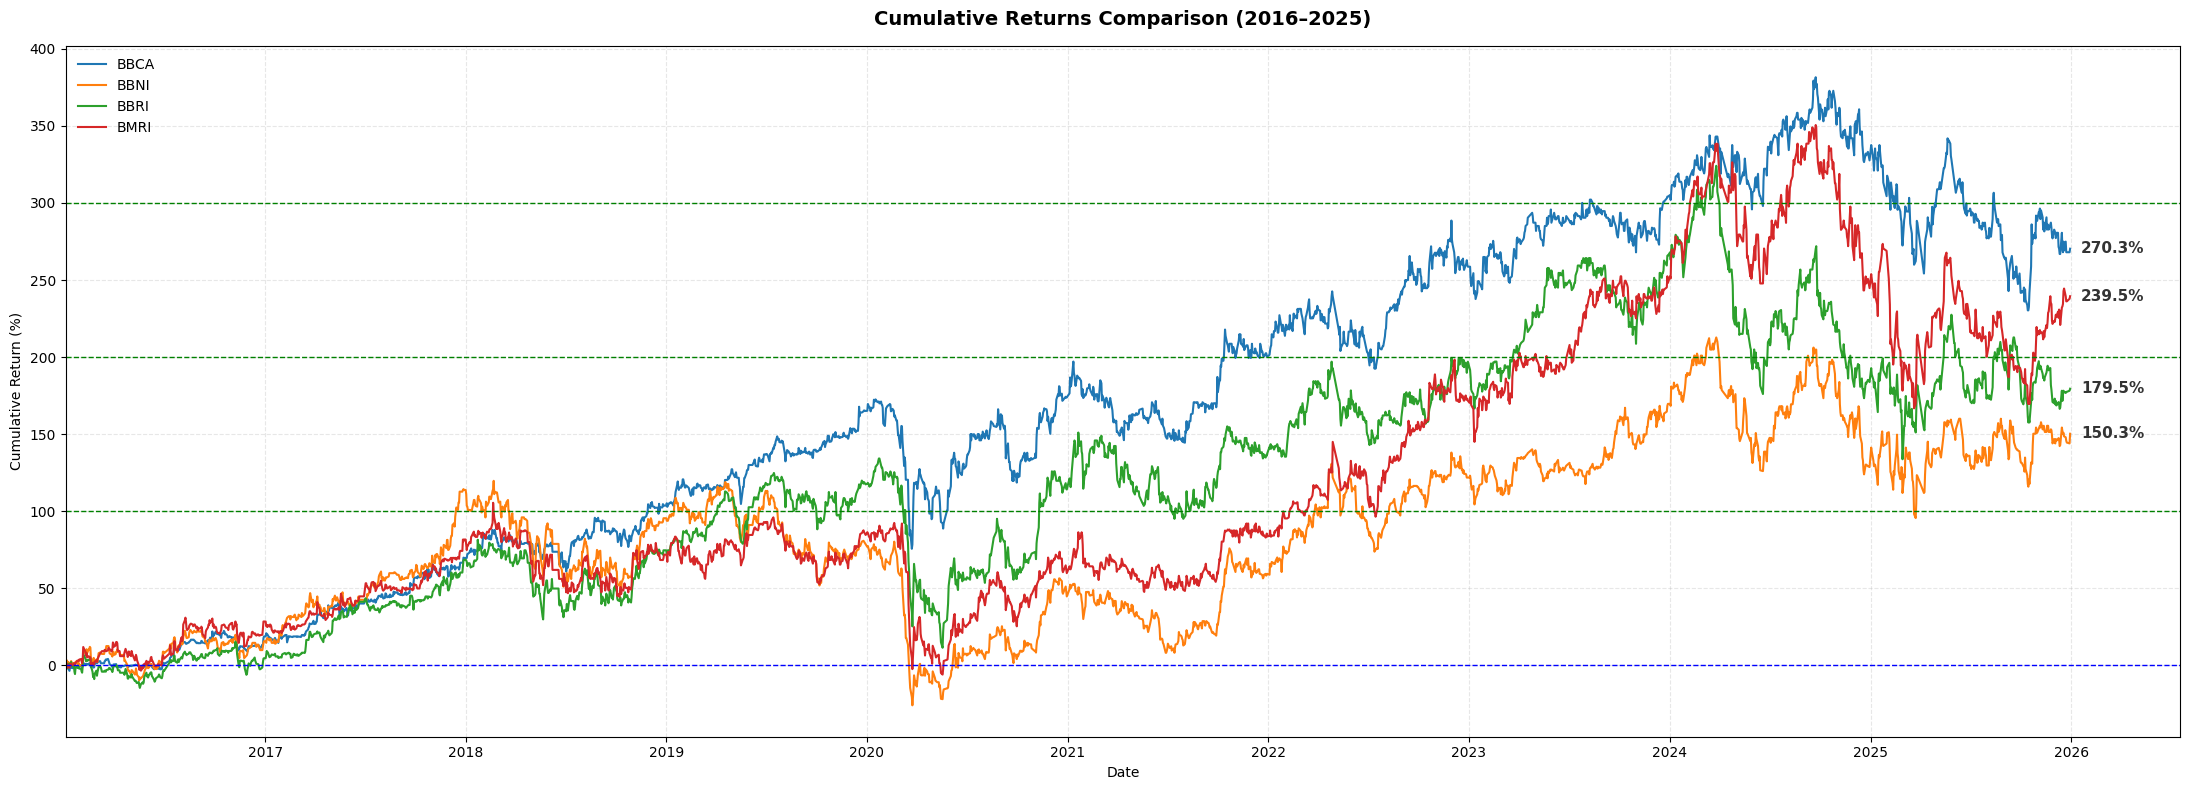

In [70]:
data_actual_plot = prices.loc['2016-01-01':'2025-12-31'].copy()
cum_ret_assets = ((data_actual_plot / data_actual_plot.iloc[0]) - 1) * 100
fig, ax = plt.subplots(figsize=(22, 8), facecolor='white')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, col in enumerate(cum_ret_assets.columns):
    ax.plot(cum_ret_assets.index,cum_ret_assets[col],linewidth=1.5,label=col.replace('.JK', ''),color=colors[i])

for y in [0, 100, 200, 300]:
    color = 'blue' if y == 0 else 'green'
    ax.axhline(y, linestyle='--', linewidth=1, color=color)

last_date = cum_ret_assets.index[-1]
offset = pd.Timedelta(days=20)
for col in cum_ret_assets.columns:
    y = cum_ret_assets[col].iloc[-1]
    ax.text(last_date + offset,y,f"{y:.1f}%",fontsize=11,va='center',fontweight='bold',color='#333333')

ax.set_title('Cumulative Returns Comparison (2016–2025)', fontsize=14, pad=15, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (%)')
ax.legend(loc='upper left', frameon=False)
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_xlim(cum_ret_assets.index[0],last_date + pd.Timedelta(days=200))
plt.tight_layout()
plt.show()

## **Drawdown Analysis**

0% Drawdown
1. Artinya portofolio tidak mengalami penurunan dari nilai tertingginya.
2. Portofolio selalu naik atau stabil, tidak ada kerugian sementara.

Drawdown positif (misal 10%, 20%)
1. Artinya portofolio turun sekian persen dari puncak sebelumnya.
2. Menunjukkan risiko penurunan nilai investasi yang pernah terjadi.

Drawdown tinggi (misal >50%)
1. Artinya portofolio mengalami penurunan besar dari puncak sebelumnya.
2. Risiko ekstrem, investor mengalami kerugian signifikan sebelum bisa kembali ke level awal.


Semakin rendah Drawdown, portofolio lebih stabil dan risiko kerugian lebih kecil.

Semakin tinggi Drawdown, portofolio lebih berisiko dan fluktuasi nilainya besar.

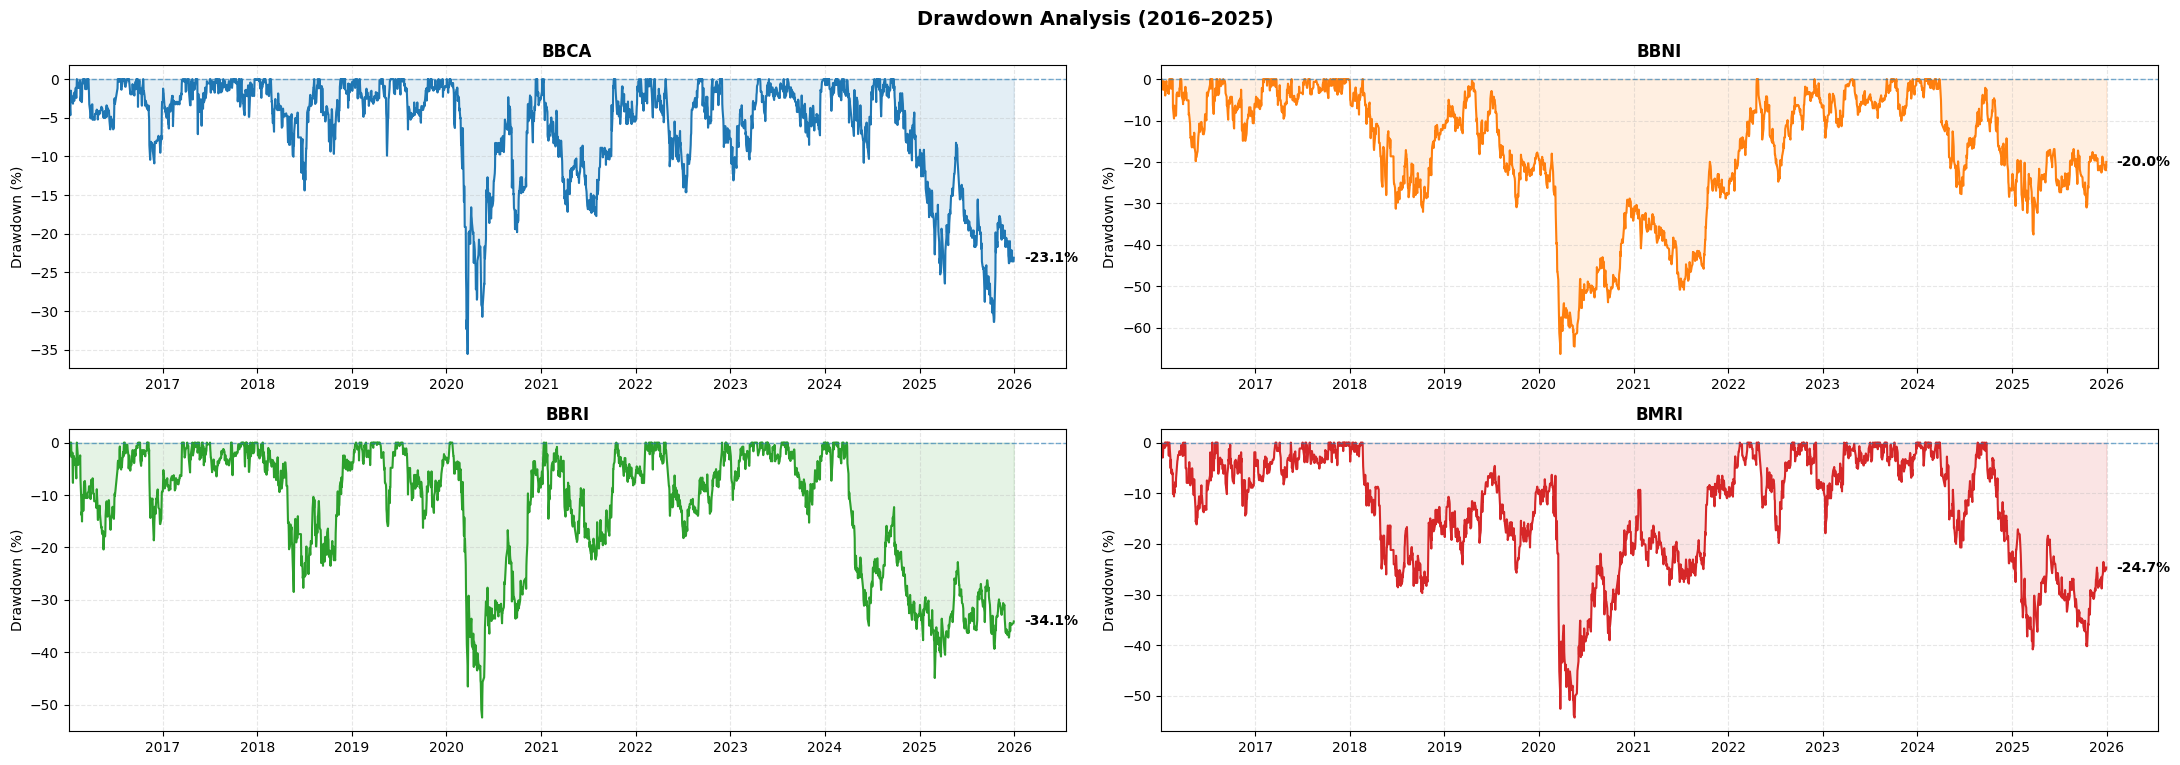

In [76]:
data_drawdown = prices.loc['2016-01-01':'2025-12-31']
rolling_max = data_drawdown.cummax()
drawdowns_pct = (data_drawdown / rolling_max - 1) * 100
fig, axes = plt.subplots(2, 2, figsize=(22, 8), sharex=False)
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, col in enumerate(drawdowns_pct.columns):
    ax = axes[i]
    ax.plot(drawdowns_pct.index,drawdowns_pct[col],linewidth=1.5,color=colors[i])
    ax.fill_between(drawdowns_pct.index,drawdowns_pct[col],0,color=colors[i],alpha=0.12)
    ax.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
    last_date = drawdowns_pct.index[-1]
    last_value = drawdowns_pct[col].iloc[-1]
    ax.text(last_date + pd.Timedelta(days=40),last_value,f"{last_value:.1f}%",fontsize=10,va='center',fontweight='bold')
    ax.set_title(col.replace('.JK', ''), fontsize=12,fontweight='bold')
    ax.set_ylabel('Drawdown (%)')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xlim(drawdowns_pct.index[0],drawdowns_pct.index[-1] + pd.Timedelta(days=200))

fig.suptitle('Drawdown Analysis (2016–2025)', fontsize=14, y=0.98,fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

## **Sharpe Ratio vs Sortino Ratio Analysis**

0 Sharpe Ratio
1. Artinya return portofolio sama dengan aset bebas risiko, tidak ada kompensasi untuk risiko.
2. Portofolio tidak menghasilkan keuntungan tambahan dibanding menaruh uang di aset aman.

Sharpe Ratio positif
1. Artinya portofolio memberikan return lebih besar dari risiko yang diambil.
2. Semakin tinggi angkanya, semakin efisien portofolio menghasilkan return per unit risiko.

Sharpe Ratio negatif
1. Artinya portofolio merugi dibanding aset bebas risiko, investor tidak mendapat kompensasi atas risiko yang diambil.
2. Menunjukkan performa portofolio buruk atau strategi tidak efektif.


Semakin tinggi Sharpe Ratio, semakin baik portofolio dalam memanfaatkan risiko untuk menghasilkan return.


Semakin rendah atau negatif, portofolio kurang efisien atau bahkan merugikan.


0 Sortino Ratio
1. Artinya return portofolio sama dengan target minimum atau aset bebas risiko.
2. Tidak ada kompensasi atas risiko kerugian.
3. Portofolio tidak memberi nilai tambah dibanding menyimpan dana di instrumen aman.

Sortino Ratio positif

1. Artinya portofolio menghasilkan return di atas target dengan risiko kerugian yang terkontrol.
2. Semakin tinggi angkanya, semakin efisien portofolio menghasilkan return tanpa banyak downside.
3. Ini menunjukkan kualitas return yang lebih stabil dan bersih.

Sortino Ratio negatif

1. Artinya return portofolio berada di bawah target atau risk-free rate.
2. Kerugian lebih dominan daripada keuntungan.
3. Investor mengambil risiko downside tanpa imbal hasil yang layak.

Semakin tinggi Sortino Ratio, semakin baik portofolio dalam menghasilkan return dengan meminimalkan kerugian.

Semakin rendah atau negatif, portofolio sering mengalami downside dan strategi cenderung tidak efektif.

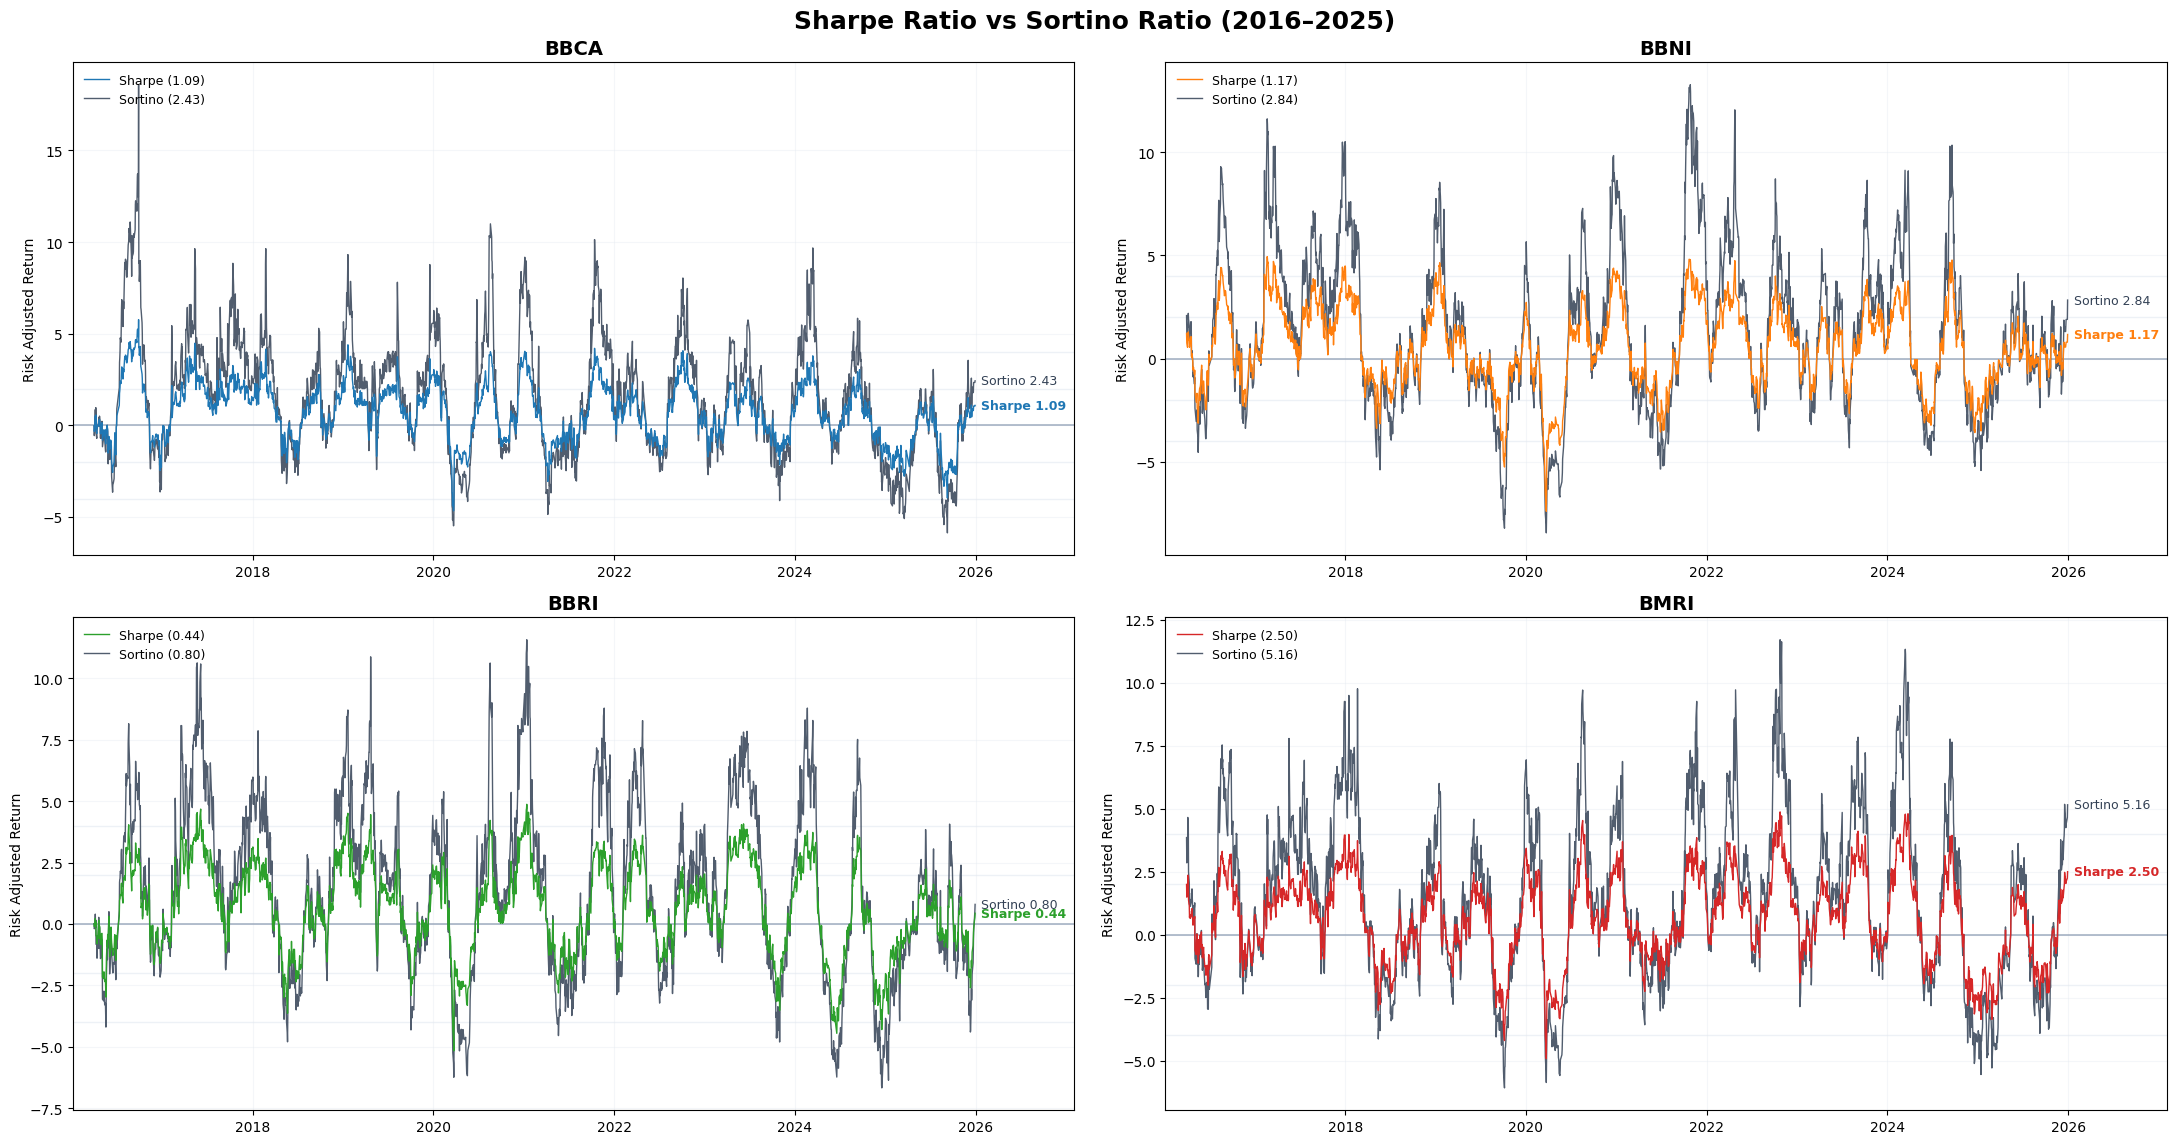

In [75]:
prices_eval = prices.loc['2016-01-01':'2025-12-31']
daily_returns = prices_eval.pct_change().dropna()
window = 60
trading_days = 252
risk_free_rate_annual = 0.04
risk_free_rate_daily = risk_free_rate_annual / trading_days
excess_returns = daily_returns - risk_free_rate_daily
rolling_sharpe = (excess_returns.rolling(window).mean() /excess_returns.rolling(window).std()) * np.sqrt(trading_days)

def calculate_rolling_sortino(returns, rf_daily, window_size, ann_factor):
    excess = returns - rf_daily
    downside = excess.copy()
    downside[downside > 0] = 0
    downside_std = downside.rolling(window_size).std()
    return (excess.rolling(window_size).mean() / downside_std) * np.sqrt(ann_factor)

rolling_sortino = calculate_rolling_sortino(daily_returns,risk_free_rate_daily,window,trading_days)
colors_sharpe = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
color_sortino = '#334155'
color_grid = '#e2e8f0'
color_zero = '#94a3b8'
fig, axes = plt.subplots(2, 2, figsize=(22, 12), sharex=False)
axes = axes.flatten()

for i, col in enumerate(daily_returns.columns[:4]):
    ax = axes[i]
    clean_name = col.replace('.JK', '')
    sharpe_series = rolling_sharpe[col]
    sortino_series = rolling_sortino[col]
    last_sharpe = sharpe_series.iloc[-1]
    last_sortino = sortino_series.iloc[-1]
    last_date = sharpe_series.index[-1]
    ax.plot(sharpe_series.index,sharpe_series,linewidth=1,color=colors_sharpe[i],label=f"Sharpe ({last_sharpe:.2f})",zorder=3)
    ax.plot(sortino_series.index,sortino_series,linewidth=1,color=color_sortino,alpha=0.85,label=f"Sortino ({last_sortino:.2f})",zorder=2)

    for y in [-4, -2, 2, 4]:
        ax.axhline(y,linestyle='-',linewidth=1,color=color_grid,alpha=0.6,zorder=1)

    ax.axhline(0,linewidth=1.1,color=color_zero,alpha=0.9,zorder=1)
    ax.text(last_date + pd.Timedelta(days=25),last_sharpe,f"Sharpe {last_sharpe:.2f}",fontsize=9,fontweight='bold',color=colors_sharpe[i],va='center')
    ax.text(last_date + pd.Timedelta(days=25),last_sortino,f"Sortino {last_sortino:.2f}",fontsize=9,color=color_sortino,va='center')
    ax.set_title(clean_name, fontsize=14, fontweight='bold')
    ax.set_ylabel("Risk Adjusted Return")
    ax.grid(True, color=color_grid, alpha=0.35)
    ax.set_axisbelow(True)
    ax.legend(loc='upper left',frameon=False,fontsize=9)
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=0, labelsize=10)
    ax.set_xlim(sharpe_series.index[0],sharpe_series.index[-1] + pd.Timedelta(days=400))

fig.suptitle("Sharpe Ratio vs Sortino Ratio (2016–2025)",fontsize=18,fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

## **Volatility Analysis**

0% volatility
1. Artinya harga aset tidak bergerak sama sekali selama periode yang dihitung.
2. Tidak ada fluktuasi harian, portofolio atau saham “stabil sempurna”.
3. Dalam praktik nyata hampir tidak pernah terjadi kecuali saham tidak diperdagangkan.

100% volatility
1. Artinya harga aset bergerak sangat besar dalam setahun.
2. Jika saham bernilai 100, bisa bergerak ±100 dalam setahun.
3. Menunjukkan risiko ekstrem, investasi sangat tidak stabil.


Semakin tinggi persentase, semakin besar fluktuasi dan risiko.

Semakin rendah persentase, harga lebih stabil, risiko lebih kecil.

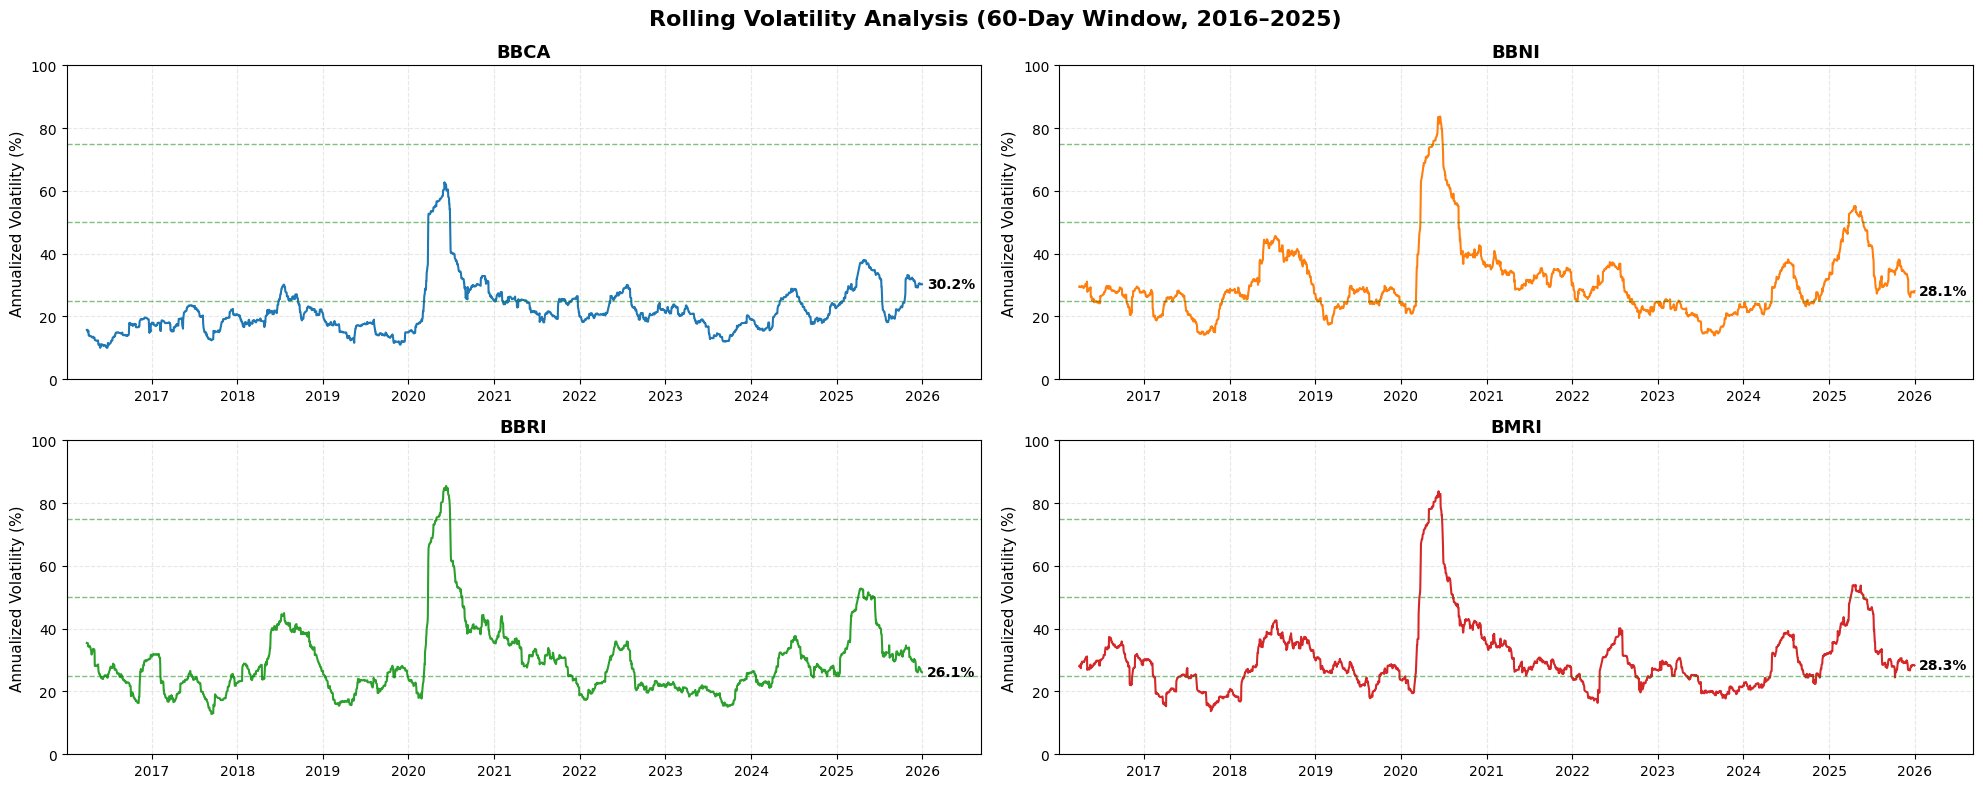

In [10]:
data_vol = prices.loc['2016-01-01':'2025-12-31']
daily_returns = data_vol.pct_change().dropna()
window = 60
rolling_vol = daily_returns.rolling(window).std() * np.sqrt(252) * 100
fig, axes = plt.subplots(2, 2, figsize=(20, 8), sharey=True)
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
y_ticks = np.arange(0, 101, 20)

for i, col in enumerate(rolling_vol.columns):
    ax = axes[i]
    ax.plot(rolling_vol.index, rolling_vol[col], linewidth=1.5, color=colors[i])

    for y in [25, 50, 75]:
        ax.axhline(y, linestyle='--', linewidth=1, alpha=0.5, color='green')

    ax.set_title(col.replace('.JK', ''), fontsize=13, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.set_yticks(y_ticks)
    ax.set_ylabel('Annualized Volatility (%)', fontsize=11)
    ax.tick_params(axis='y', labelleft=True)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, linestyle='--', alpha=0.3)
    last_date = rolling_vol.index[-1]
    val = rolling_vol[col].iloc[-1]

    if not np.isnan(val):
        ax.text(last_date + pd.Timedelta(days=20), val, f"{val:.1f}%", fontsize=10, fontweight='bold', va='center')

    ax.set_xlim(rolling_vol.index[0], last_date + pd.Timedelta(days=250))

fig.suptitle('Rolling Volatility Analysis (60-Day Window, 2016–2025)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## **Correlation Heatmap**

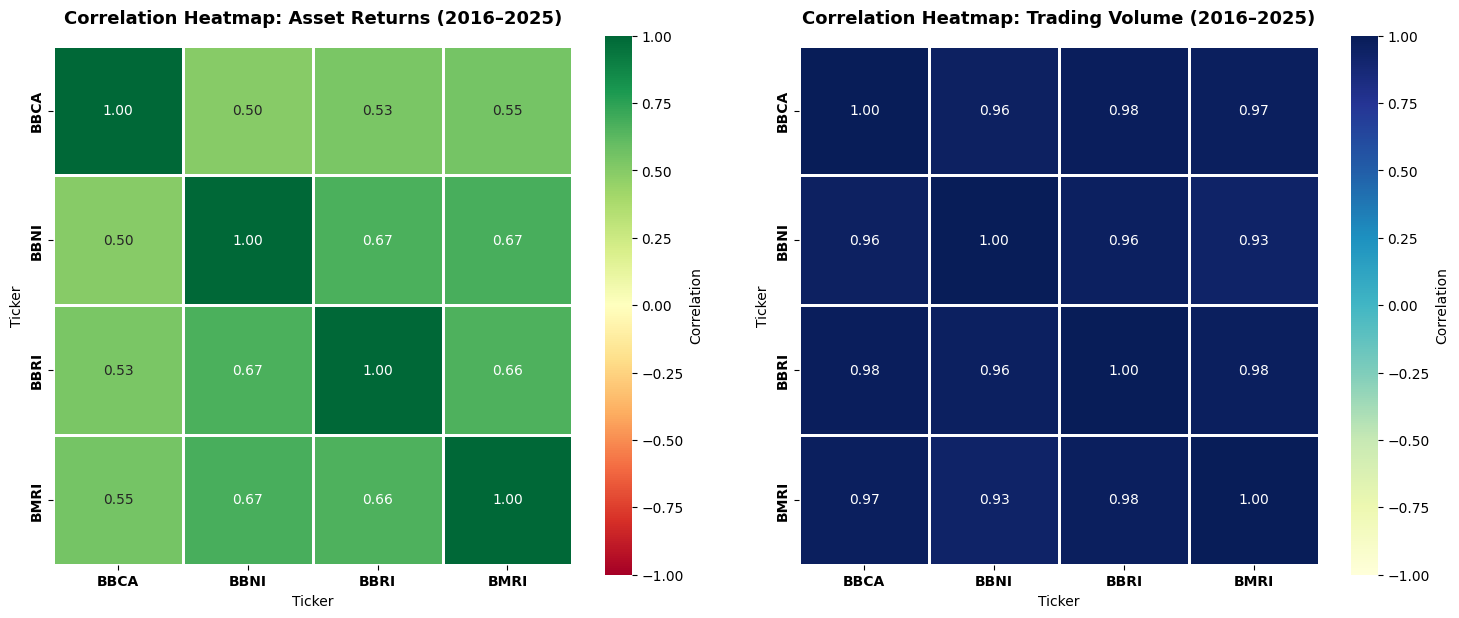

In [11]:
prices_eval = prices.loc['2016-01-01':'2025-12-31']
prices_eval.columns = prices_eval.columns.str.replace('.JK', '', regex=False)
daily_returns = prices_eval.pct_change().dropna()
corr_matrix_ret = daily_returns.corr()
volume_eval = volume.loc['2016-01-01':'2025-12-31']
volume_eval.columns = volume_eval.columns.str.replace('.JK', '', regex=False)
volume_returns = np.log(volume_eval.replace(0, 1) / volume_eval.shift(1).replace(0, 1)).dropna()
volume_returns = volume_returns.replace([np.inf, -np.inf], 0).fillna(0)
corr_matrix_vol = volume_returns.corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), facecolor='white')

sns.heatmap(corr_matrix_ret, annot=True, fmt=".2f", cmap='RdYlGn', vmin=-1, vmax=1, square=True, linewidths=1, annot_kws={"fontsize": 10}, cbar_kws={"label": "Correlation"}, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), fontweight='bold')
ax1.set_yticklabels(ax1.get_yticklabels(), fontweight='bold')
ax1.set_title("Correlation Heatmap: Asset Returns (2016–2025)", fontsize=13, pad=16, fontweight='bold')

sns.heatmap(corr_matrix_vol, annot=True, fmt=".2f", cmap='YlGnBu', vmin=-1, vmax=1, square=True, linewidths=1, annot_kws={"fontsize": 10}, cbar_kws={"label": "Correlation"}, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), fontweight='bold')
ax2.set_yticklabels(ax2.get_yticklabels(), fontweight='bold')
ax2.set_title("Correlation Heatmap: Trading Volume (2016–2025)", fontsize=13, pad=16, fontweight='bold')

plt.subplots_adjust(wspace=0.15)
plt.show()

# **Result Model , Equal Weight & Mean Variance**

In [12]:
results_df = pd.DataFrame(portfolio_values, index=dates_history)
weights_df = pd.DataFrame(weights_history,index=dates_history,columns=TICKERS)

def calculate_performance_metrics(equity_curve):
    total_return = equity_curve.iloc[-1] / equity_curve.iloc[0] - 1
    days = (equity_curve.index[-1] - equity_curve.index[0]).days
    annual_return = (1 + total_return) ** (365 / days) - 1
    daily_returns = equity_curve.pct_change().dropna()
    annual_volatility = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    return [total_return * 100,annual_return * 100,annual_volatility * 100,sharpe_ratio,max_drawdown * 100]

metrics_table = pd.DataFrame(
    {
        "Deep Learning": calculate_performance_metrics(results_df["Model"]),
        "Equal Weight": calculate_performance_metrics(results_df["EqualWeight"]),
        "Mean Variance": calculate_performance_metrics(results_df["MeanVariance"])
    },
    index=[
        "Total Return (%)",
        "Annualized Return (%)",
        "Annualized Volatility (%)",
        "Sharpe Ratio",
        "Max Drawdown (%)"
    ]
)

metrics_table = metrics_table.round(2)
metrics_table

Deep Learning  Equal Weight  Mean Variance
Total Return (%)                  147.74        145.57          35.79
Annualized Return (%)               9.50          9.41           3.11
Annualized Volatility (%)          24.29         23.47          23.34
Sharpe Ratio                        0.39          0.40           0.13
Max Drawdown (%)                  -46.91        -45.77         -35.47

## **Cumulative Returns**

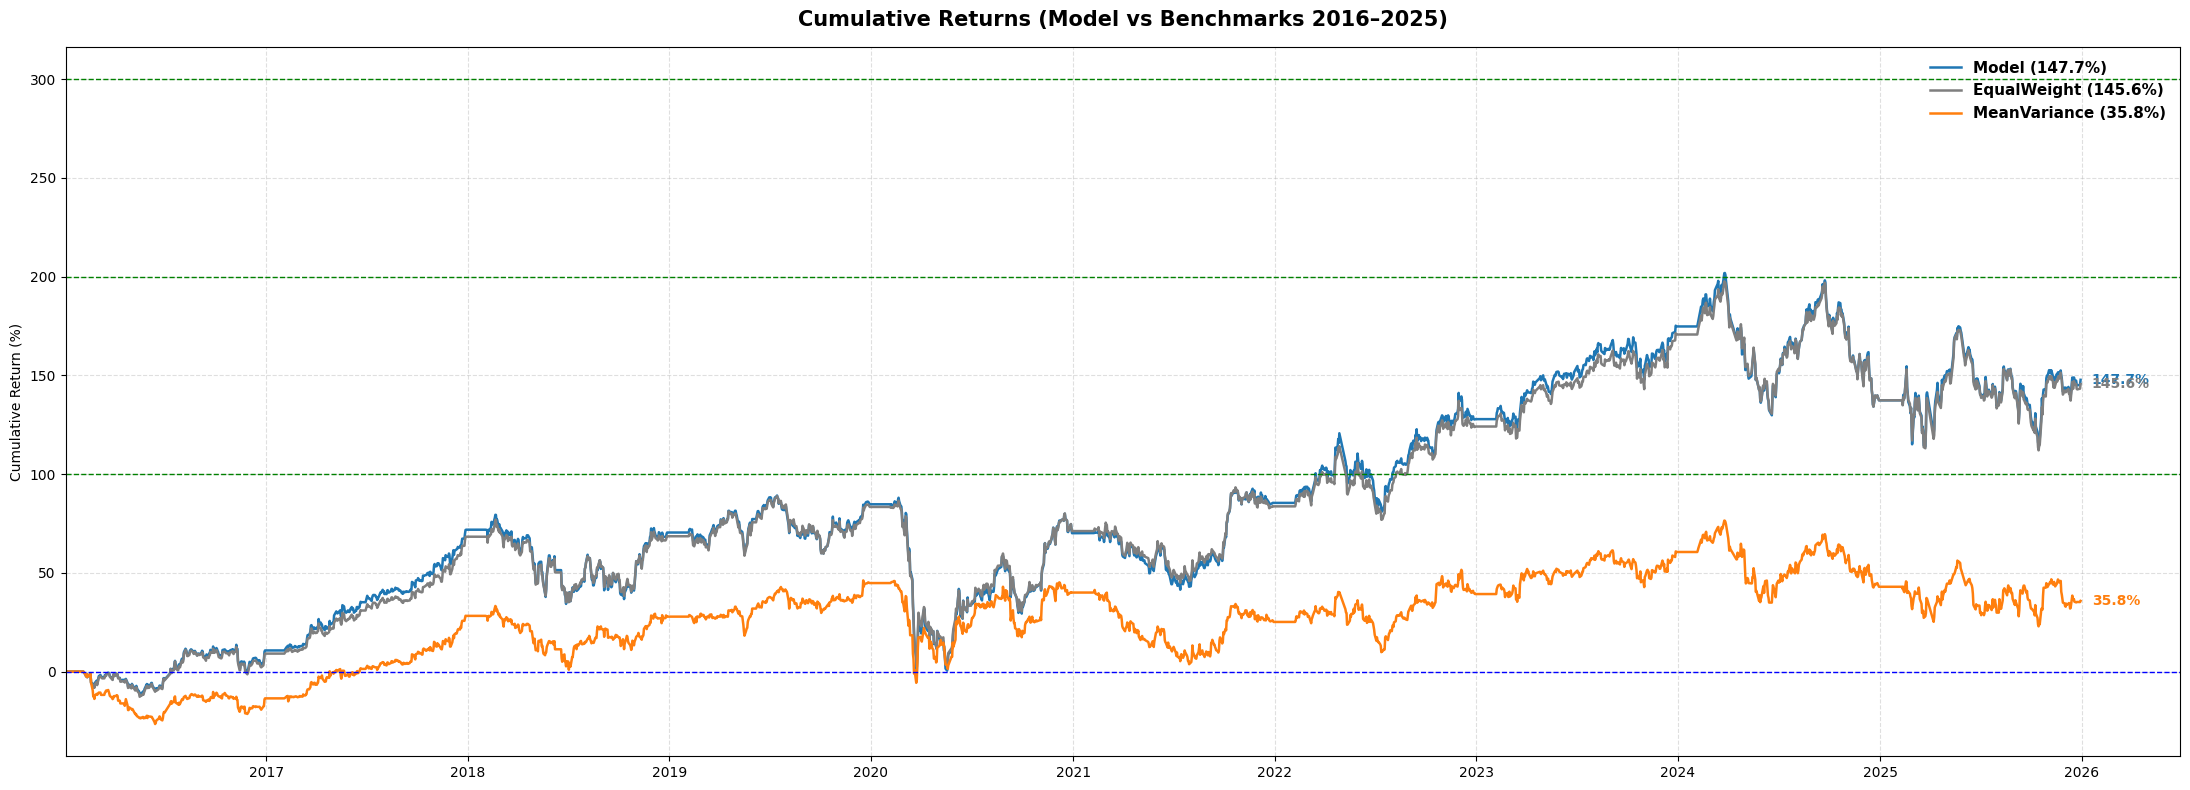

In [103]:
cumulative_returns_pct = (results_df / results_df.iloc[0] - 1) * 100
fig, ax = plt.subplots(figsize=(22, 8))

colors = {
    'Model': '#1f77b4',
    'EqualWeight': '#7f7f7f',
    'MeanVariance': '#ff7f0e'
}

styles = {
    'Model': '-',
    'EqualWeight': '-',
    'MeanVariance': '-'
}

for col in cumulative_returns_pct.columns:
    final_ret = cumulative_returns_pct[col].iloc[-1]
    label = f"{col} ({final_ret:.1f}%)"
    ax.plot(cumulative_returns_pct.index,cumulative_returns_pct[col],label=label,linewidth=1.8,linestyle=styles[col],color=colors[col])

for y in [0, 100, 200, 300]:
    color = 'blue' if y == 0 else 'green'
    ax.axhline(y, linestyle='--', linewidth=1,color=color)

last_x = cumulative_returns_pct.index[-1]
offset = pd.Timedelta(days=20)

for col in cumulative_returns_pct.columns:
    y = cumulative_returns_pct[col].iloc[-1]
    ax.text(last_x + offset,y,f"{y:.1f}%",va='center',fontsize=10,fontweight='bold' ,color=colors[col])

ax.set_title('Cumulative Returns (Model vs Benchmarks 2016–2025)',fontsize=15,pad=15,fontweight='bold')
ax.set_ylabel('Cumulative Return (%)')
ax.legend(frameon=False, prop={'size': 11, 'weight': 'bold'}, loc='upper right')
ax.grid(True, linestyle='--', alpha=0.4)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_xlim(cumulative_returns_pct.index[0],cumulative_returns_pct.index[-1] + pd.Timedelta(days=180))
plt.tight_layout()
plt.show()

## **Yearly Sharpe Ratio Comparison**

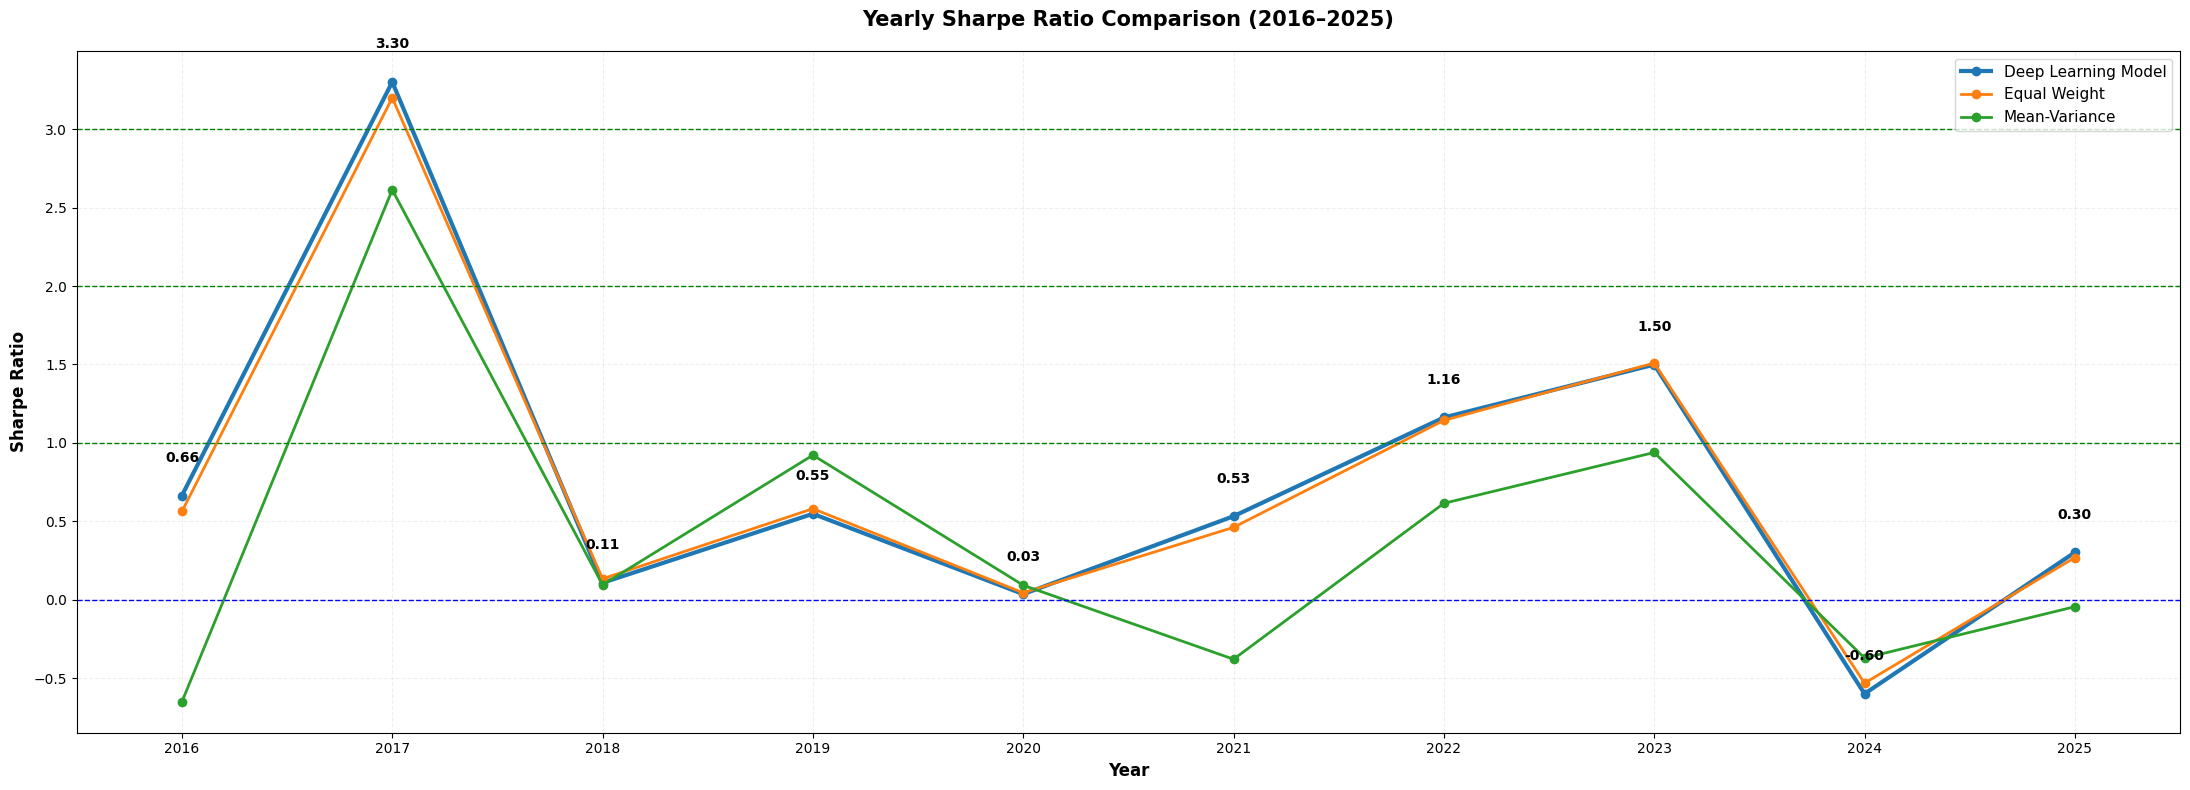

In [108]:
df_portfolio = pd.DataFrame(portfolio_values, index=dates_history)
df_portfolio.index = pd.to_datetime(df_portfolio.index)
df_daily_returns = df_portfolio.pct_change().dropna()

def calculate_yearly_sharpe(group):
    ann_return = group.mean() * 252
    ann_vol = group.std() * np.sqrt(252)
    return ann_return / (ann_vol + 1e-8)

yearly_sharpe = df_daily_returns.groupby(df_daily_returns.index.year).apply(calculate_yearly_sharpe)
yearly_sharpe = yearly_sharpe.loc[2016:2025]
plt.figure(figsize=(22, 8), facecolor="white")
years = yearly_sharpe.index.astype(int)
plt.plot(years, yearly_sharpe["Model"], marker="o", linewidth=3, label="Deep Learning Model", color="#1f77b4")
plt.plot(years, yearly_sharpe["EqualWeight"], marker="o", linewidth=2,label="Equal Weight", color="#ff7f0e")
plt.plot(years, yearly_sharpe["MeanVariance"], marker="o", linewidth=2,label="Mean-Variance", color="#2ca02c")
y_range = yearly_sharpe["Model"].max() - yearly_sharpe["Model"].min()
offset = y_range * 0.05 if y_range != 0 else 0.1

for x, y in zip(years, yearly_sharpe["Model"]):
    plt.text(x, y + offset, f"{y:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Yearly Sharpe Ratio Comparison (2016–2025)", fontsize=15, fontweight="bold", pad=18)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")
plt.xticks(range(int(min(years)), int(max(years)) + 1))
plt.xlim(min(years) - 0.5, max(years) + 0.5)

for y in [0, 1, 2, 3]:
    color = 'blue' if y == 0 else 'green'
    plt.axhline(y, linestyle='--', linewidth=1, color=color)

plt.legend(frameon=True, fontsize=11, loc='upper right')
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()

## **Yearly Annualized Volatility Comparison**

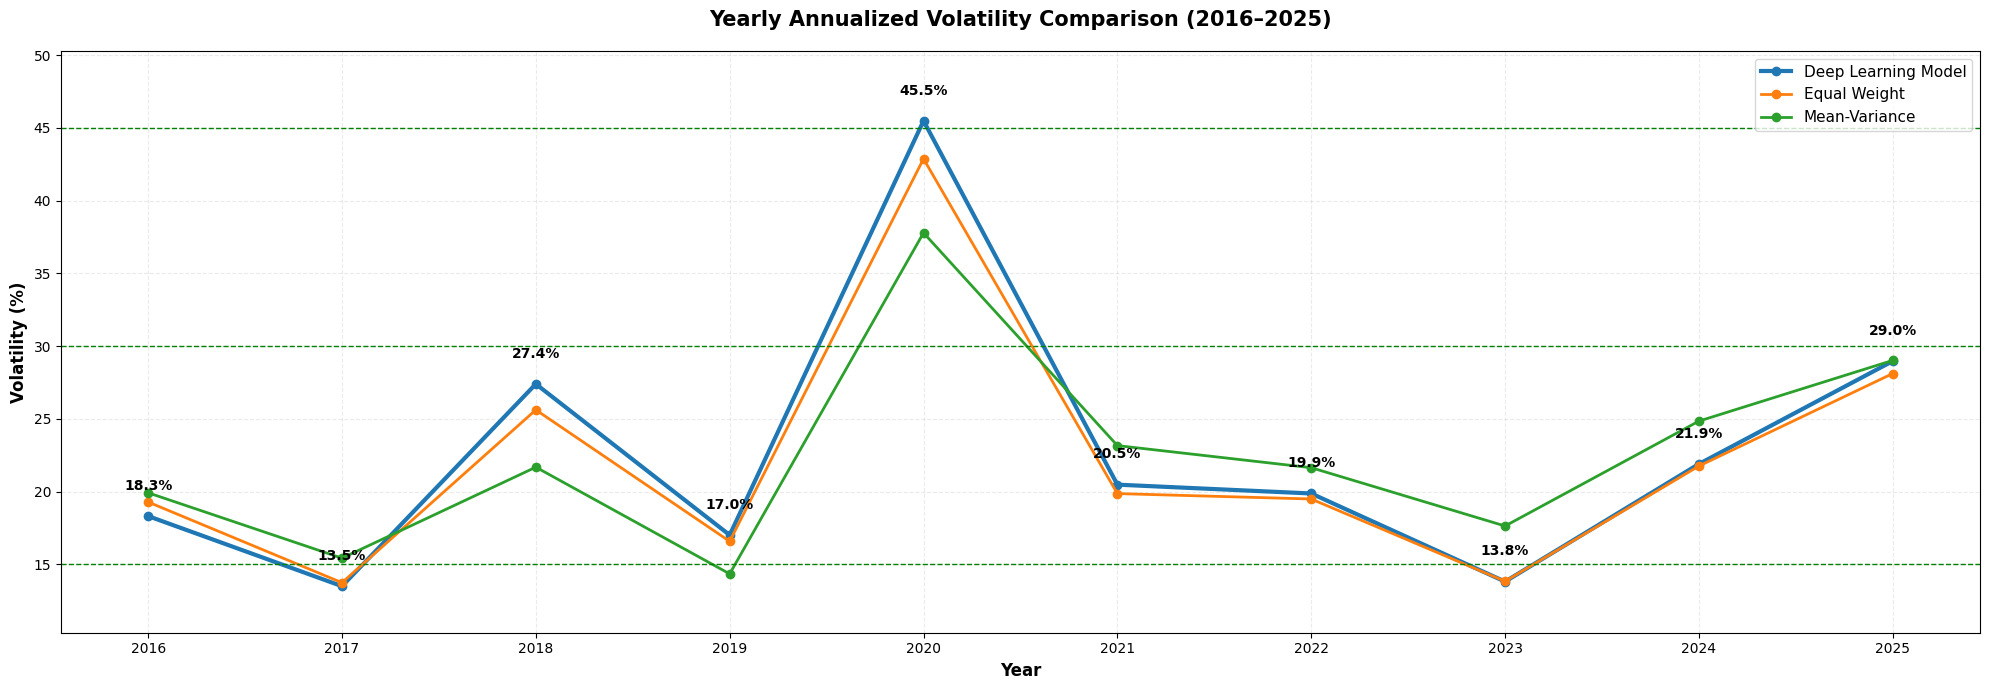

In [110]:
df_daily_returns = results_df.pct_change().dropna()
yearly_vol = (df_daily_returns.groupby(df_daily_returns.index.year).std()* np.sqrt(252)* 100)
yearly_vol = yearly_vol.loc[2016:2025]
years = yearly_vol.index
plt.figure(figsize=(20, 7), facecolor="white")
plt.plot(years,yearly_vol["Model"],marker="o",linewidth=3,label="Deep Learning Model")
plt.plot(years,yearly_vol["EqualWeight"],marker="o",linewidth=2,label="Equal Weight")
plt.plot(years,yearly_vol["MeanVariance"],marker="o",linewidth=2,label="Mean-Variance")
y_range = yearly_vol["Model"].max() - yearly_vol["Model"].min()
offset = y_range * 0.05 if y_range != 0 else 0.5

for x, y in zip(years, yearly_vol["Model"]):
    plt.text(x,y + offset,f"{y:.1f}%",ha="center",va="bottom",fontsize=10,fontweight="bold")

for y in [15, 30, 45]:
    plt.axhline(y, linestyle="--", linewidth=1, color="green")

plt.title("Yearly Annualized Volatility Comparison (2016–2025)", fontsize=15, fontweight="bold", pad=18)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(yearly_vol.min().min() - offset * 2,yearly_vol.max().max() + offset * 3)
plt.legend(frameon=True, fontsize=11, loc='upper right')
plt.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()

## **Drawdown Analysis**

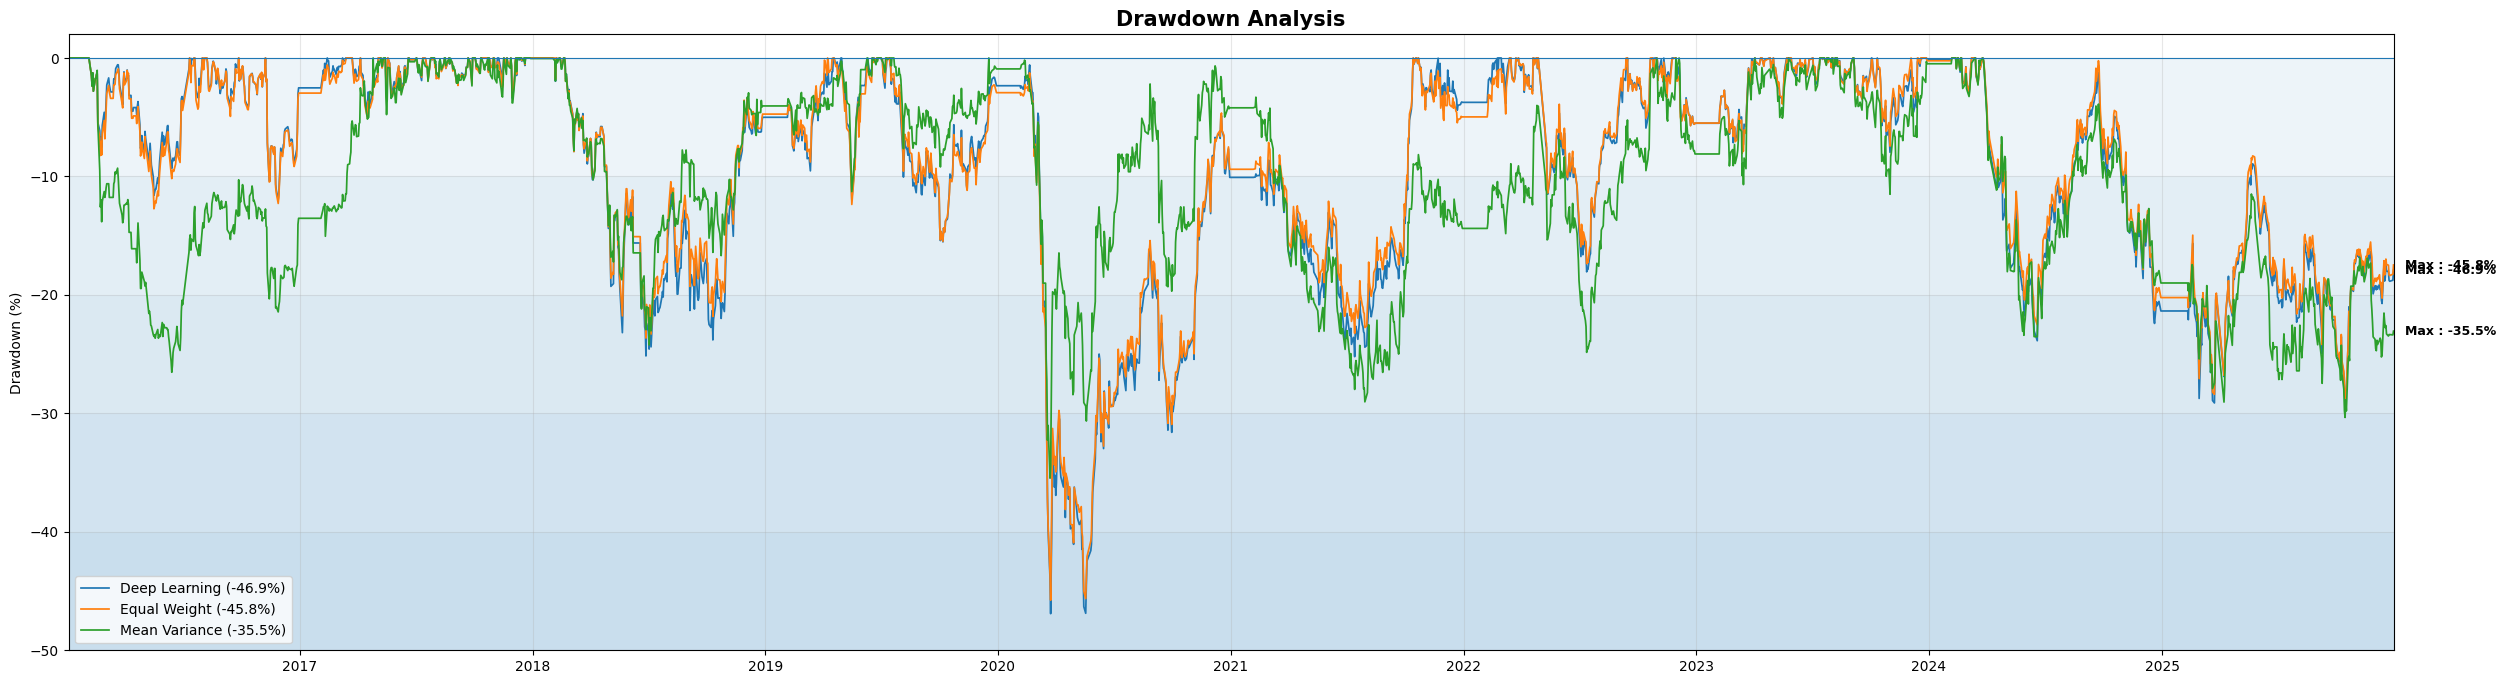

In [81]:
strategies = {
    "Deep Learning": results_df["Model"],
    "Equal Weight": results_df["EqualWeight"],
    "Mean Variance": results_df["MeanVariance"]
}

fig, ax = plt.subplots(figsize=(30, 8))
ax.axhspan(-10, 0, alpha=0.08)
ax.axhspan(-20, -10, alpha=0.12)
ax.axhspan(-30, -20, alpha=0.16)
ax.axhspan(-40, -30, alpha=0.20)
ax.axhspan(-50, -40, alpha=0.24)

for name, equity in strategies.items():
    rolling_max = equity.cummax()
    drawdown = (equity - rolling_max) / rolling_max * 100
    max_dd = drawdown.min()
    label = f"{name} ({max_dd:.1f}%)"
    ax.plot(drawdown.index, drawdown, linewidth=1.25, label=label)
    x_last = drawdown.index[-1]
    y_last = drawdown.iloc[-1]
    ax.annotate(f"Max : {max_dd:.1f}%",xy=(x_last, y_last),xytext=(8, 0),textcoords="offset points",va="center",ha="left",fontsize=9,fontweight="bold")

ax.axhline(0, linewidth=0.8)
ax.set_xlim(results_df.index[0], results_df.index[-1])
ax.margins(x=0)
ax.set_title("Drawdown Analysis",fontsize=15, fontweight="bold")
ax.set_ylabel("Drawdown (%)")
ax.set_ylim(-50, 2)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# **Result Deep Learning Model Strategy**

## **Portfolio Allocation per Year**

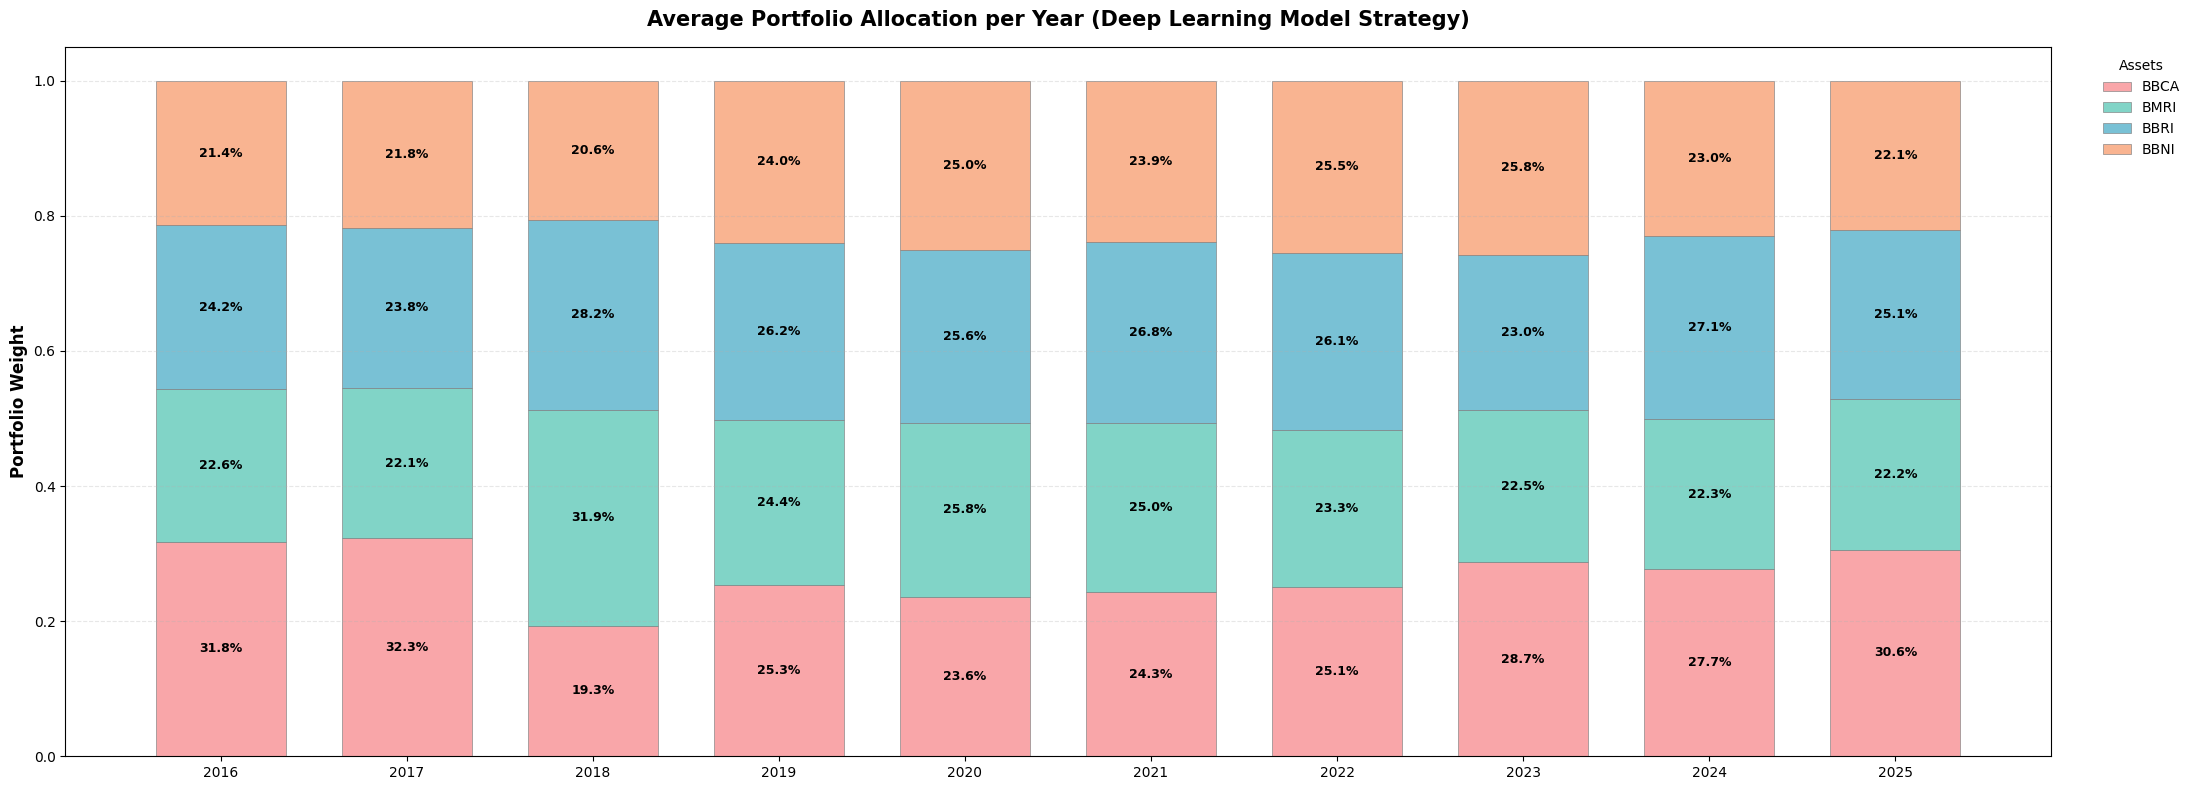

In [111]:
yearly_weights = weights_df.groupby(weights_df.index.year).mean()
fig, ax = plt.subplots(figsize=(22, 8), facecolor="white")
years = yearly_weights.index
bottom = np.zeros(len(years))
colors_bar = ['#f99da0', '#73d0c1', '#6bbbd1', '#f9ac85']

for i, ticker in enumerate(TICKERS):
    values = yearly_weights[ticker].values
    ax.bar(years,values,bottom=bottom,label=ticker.replace(".JK", ""),color=colors_bar[i],alpha=0.9,edgecolor="grey",linewidth=0.5,width=0.7)

    for j, val in enumerate(values):
        if val > 0.05:
            ax.text(years[j],bottom[j] + val / 2,f"{val*100:.1f}%",ha="center",va="center",fontsize=9,fontweight="bold")
    bottom += values

ax.set_title("Average Portfolio Allocation per Year (Deep Learning Model Strategy)", fontsize=15, fontweight="bold", pad=15)
ax.set_ylabel("Portfolio Weight", fontsize=12, fontweight="bold")
ax.set_ylim(0, 1.05)
ax.set_xticks(years)
ax.legend(title="Assets", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## **Annualized Return per Year**

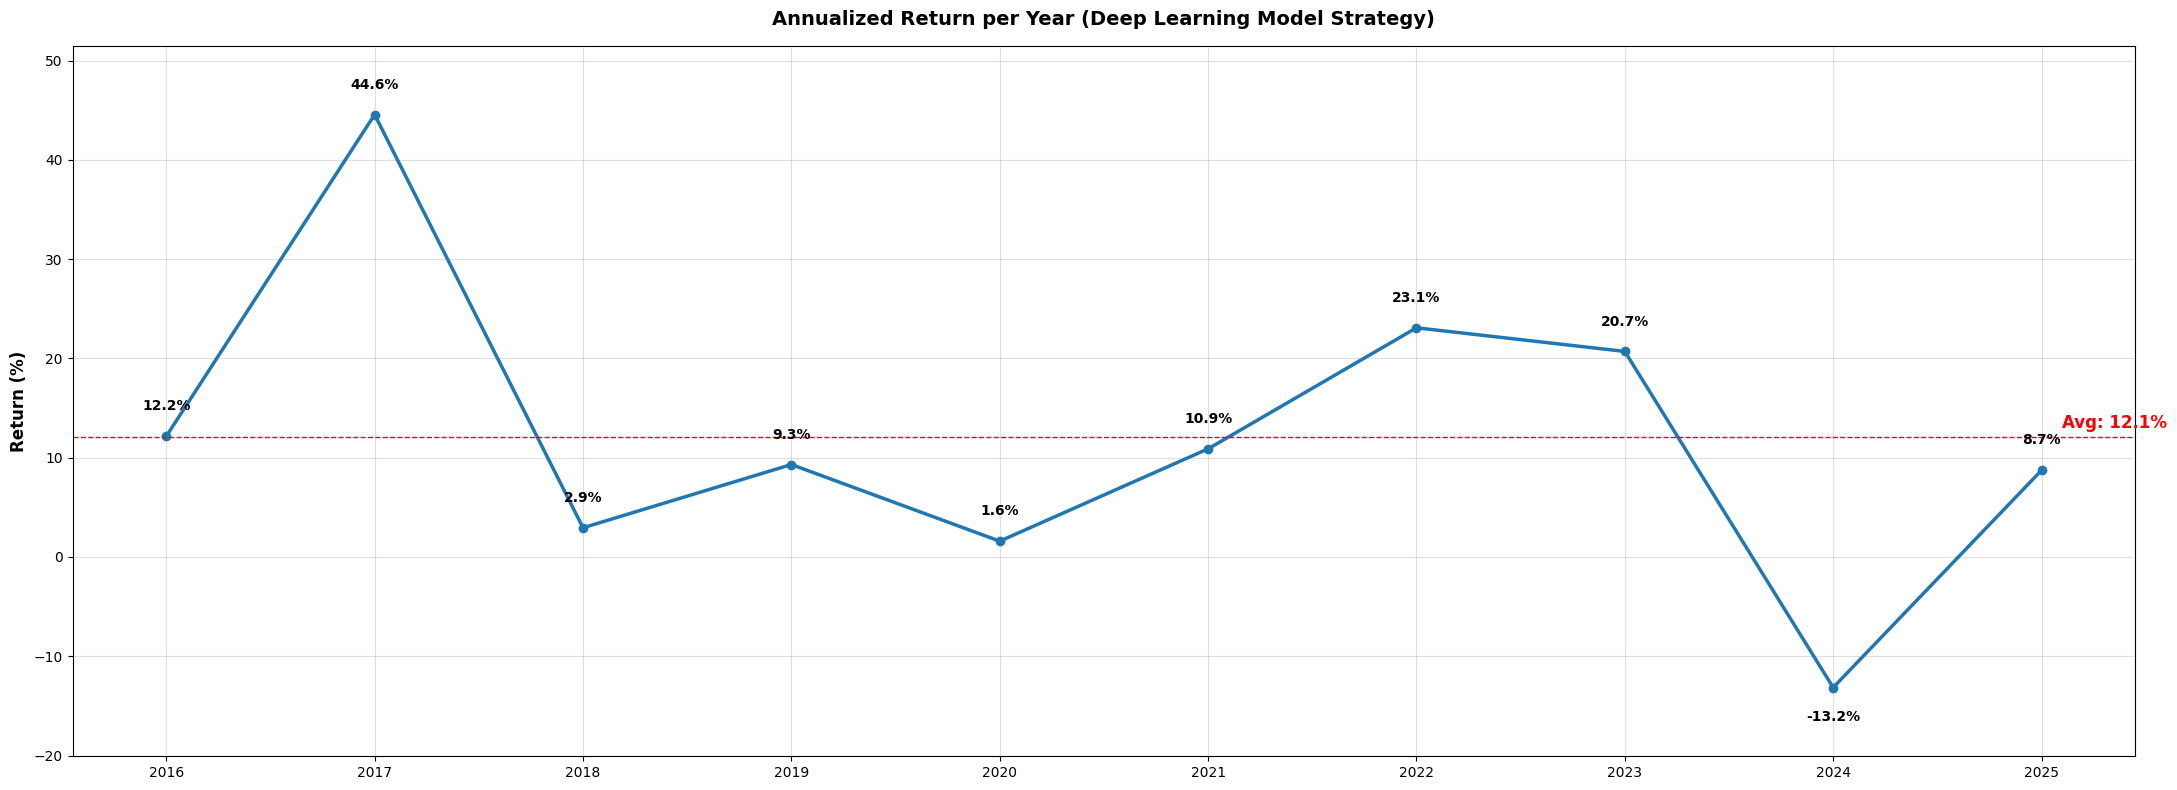

In [113]:
daily_rets_sim = results_df.pct_change().dropna()
yearly_ann_return = daily_rets_sim.groupby(daily_rets_sim.index.year).mean() * 252
yearly_ann_vol = daily_rets_sim.groupby(daily_rets_sim.index.year).std() * np.sqrt(252)
yearly_ann_sharpe = yearly_ann_return / yearly_ann_vol
years = yearly_ann_return.index
values = yearly_ann_return["Model"] * 100
plt.figure(figsize=(22, 8), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#1f77b4')
y_range = values.max() - values.min()
offset = y_range * 0.04 if y_range != 0 else 0.5

for x, y in zip(years, values):
    va = "bottom" if y >= 0 else "top"
    y_text = y + offset if y >= 0 else y - offset
    plt.text(x, y_text, f"{y:.1f}%", ha="center", va=va, fontsize=10, fontweight="bold")

avg_return = values.mean()
plt.axhline(avg_return, color='red', linestyle='--', linewidth=1)
offset_label = 0.5
plt.text(years[-1] + 0.1, avg_return + offset_label, f'Avg: {avg_return:.1f}%', color='red', va='bottom', fontsize=12, fontweight="bold")
plt.title("Annualized Return per Year (Deep Learning Model Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Return (%)", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values.min() - offset * 3, values.max() + offset * 3)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

## **Annualized Volatility per Year**

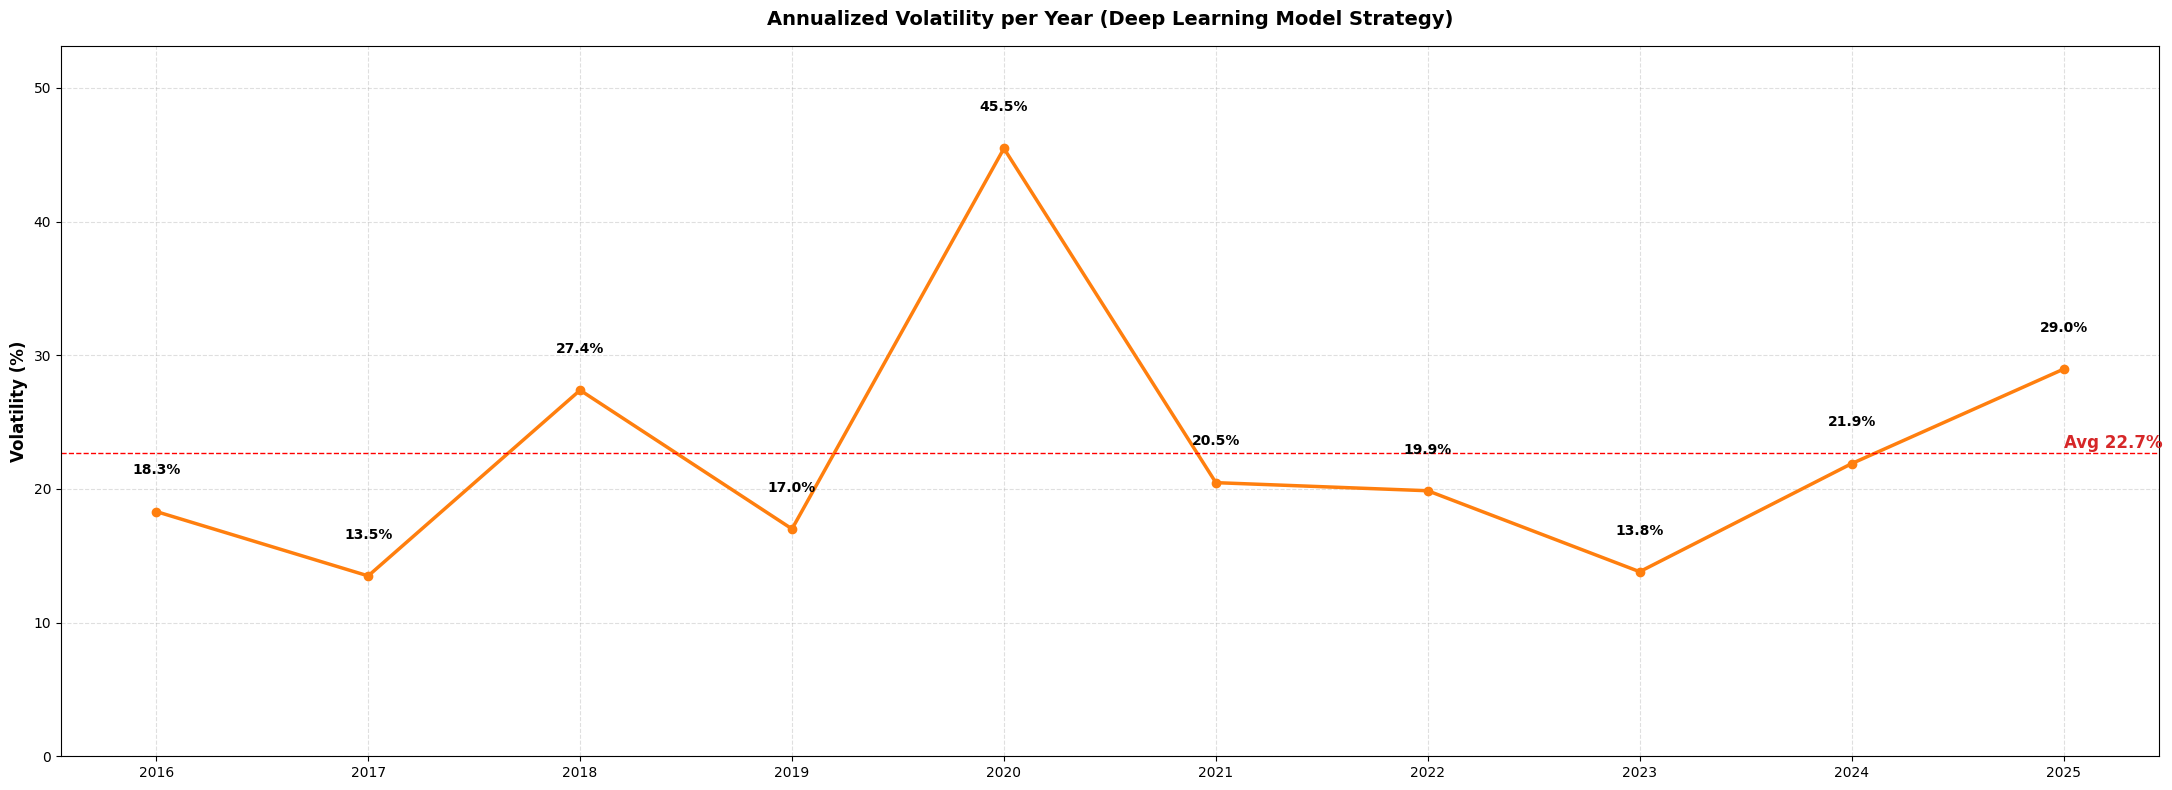

In [114]:
values = yearly_ann_vol["Model"] * 100
plt.figure(figsize=(22, 8), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color="#ff7f0e")
y_range = values.max() - values.min()
offset = y_range * 0.08 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x,y + offset,f"{y:.1f}%",ha="center",va="bottom",fontsize=10,fontweight="bold")

avg_val = values.mean()
plt.axhline(avg_val, color='red', linestyle='--', linewidth=1)
offset_label = 0.75
plt.text(years[-1],avg_val + offset_label,f"Avg {avg_val:.1f}%",ha="left",va="center",fontsize=12,fontweight="bold",color="#d62728")
plt.title("Annualized Volatility per Year (Deep Learning Model Strategy)",fontsize=14,fontweight="bold",pad=15)
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(0, values.max() + offset * 3)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## **Annualized Sharpe Ratio**

0 = Break even

1 = Good

2 = Very Good

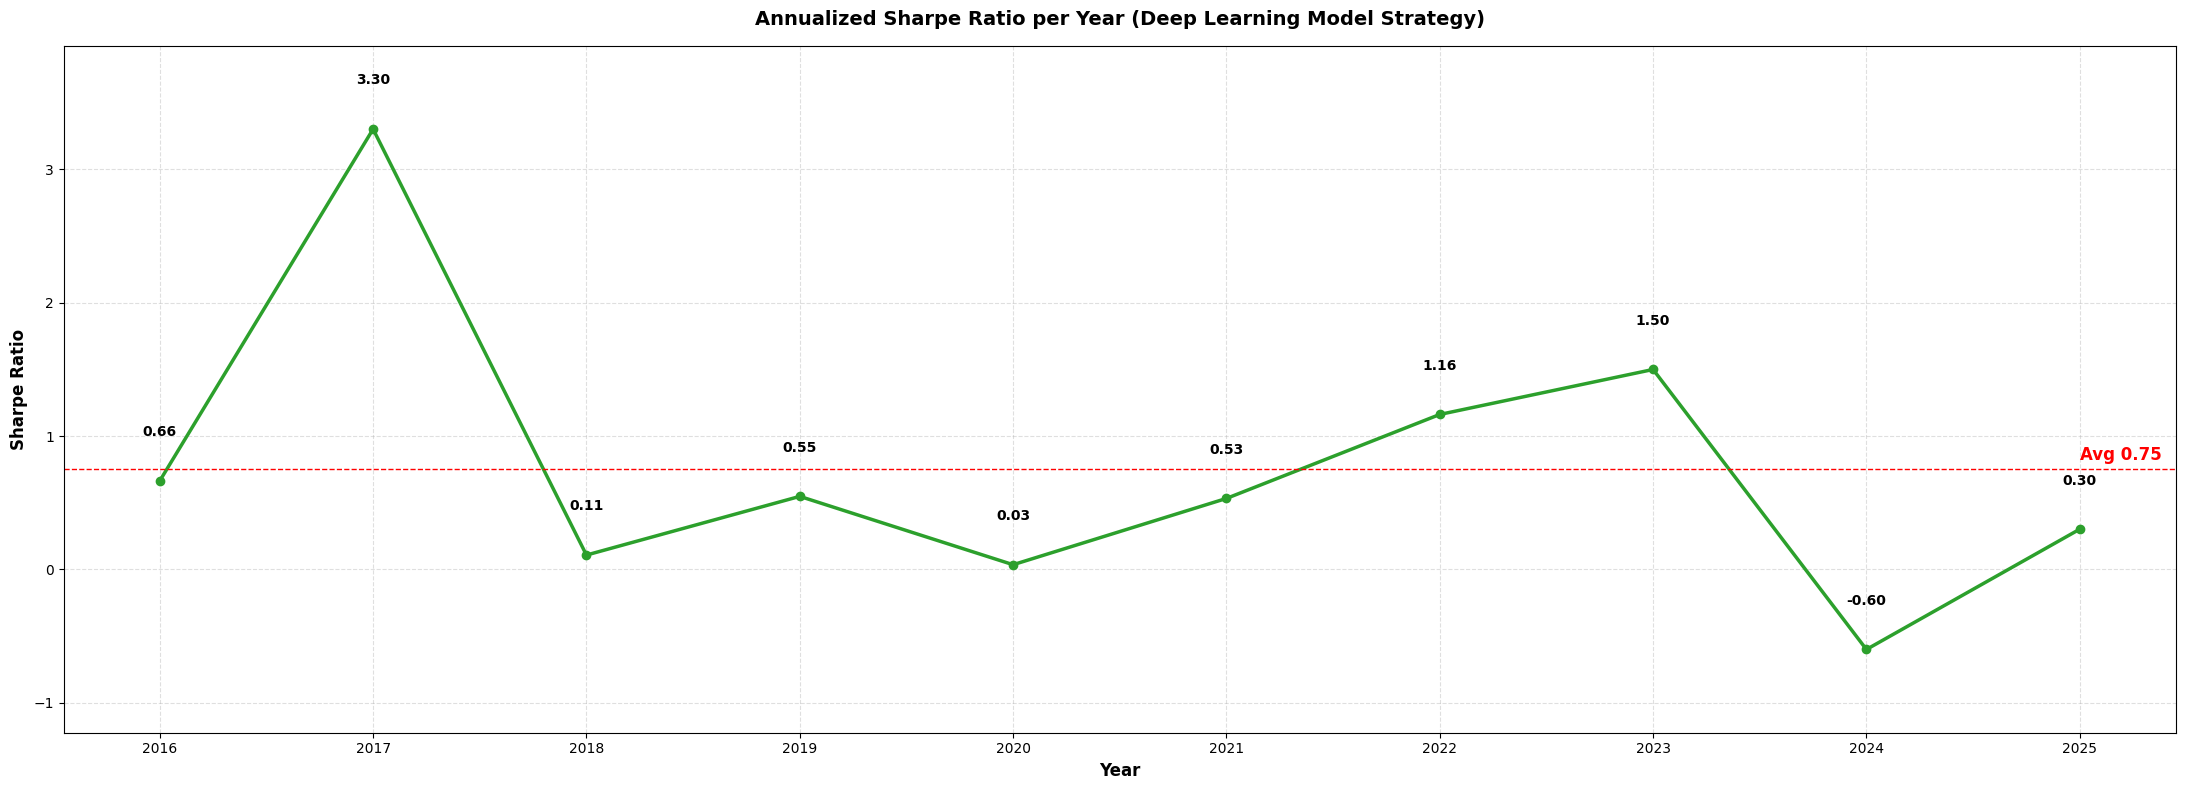

In [115]:
values = yearly_ann_sharpe["Model"]
plt.figure(figsize=(22, 8), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color="#2ca02c")
y_range = values.max() - values.min()
offset = y_range * 0.08 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x,y + offset,f"{y:.2f}",ha="center",va="bottom",fontsize=10,fontweight="bold")

avg_val = values.mean()
plt.axhline(avg_val, linewidth=1, linestyle="--", color="red")
offset_label = 0.1
plt.text(years[-1],avg_val + offset_label,f"Avg {avg_val:.2f}",ha="left",va="center",fontsize=12,fontweight="bold",color="red")
plt.title("Annualized Sharpe Ratio per Year (Deep Learning Model Strategy)",fontsize=14,fontweight="bold",pad=15)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values.min() - offset * 2, values.max() + offset * 2)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# **Result Equal Weight Strategy**

## **Portfolio Allocation per Year**

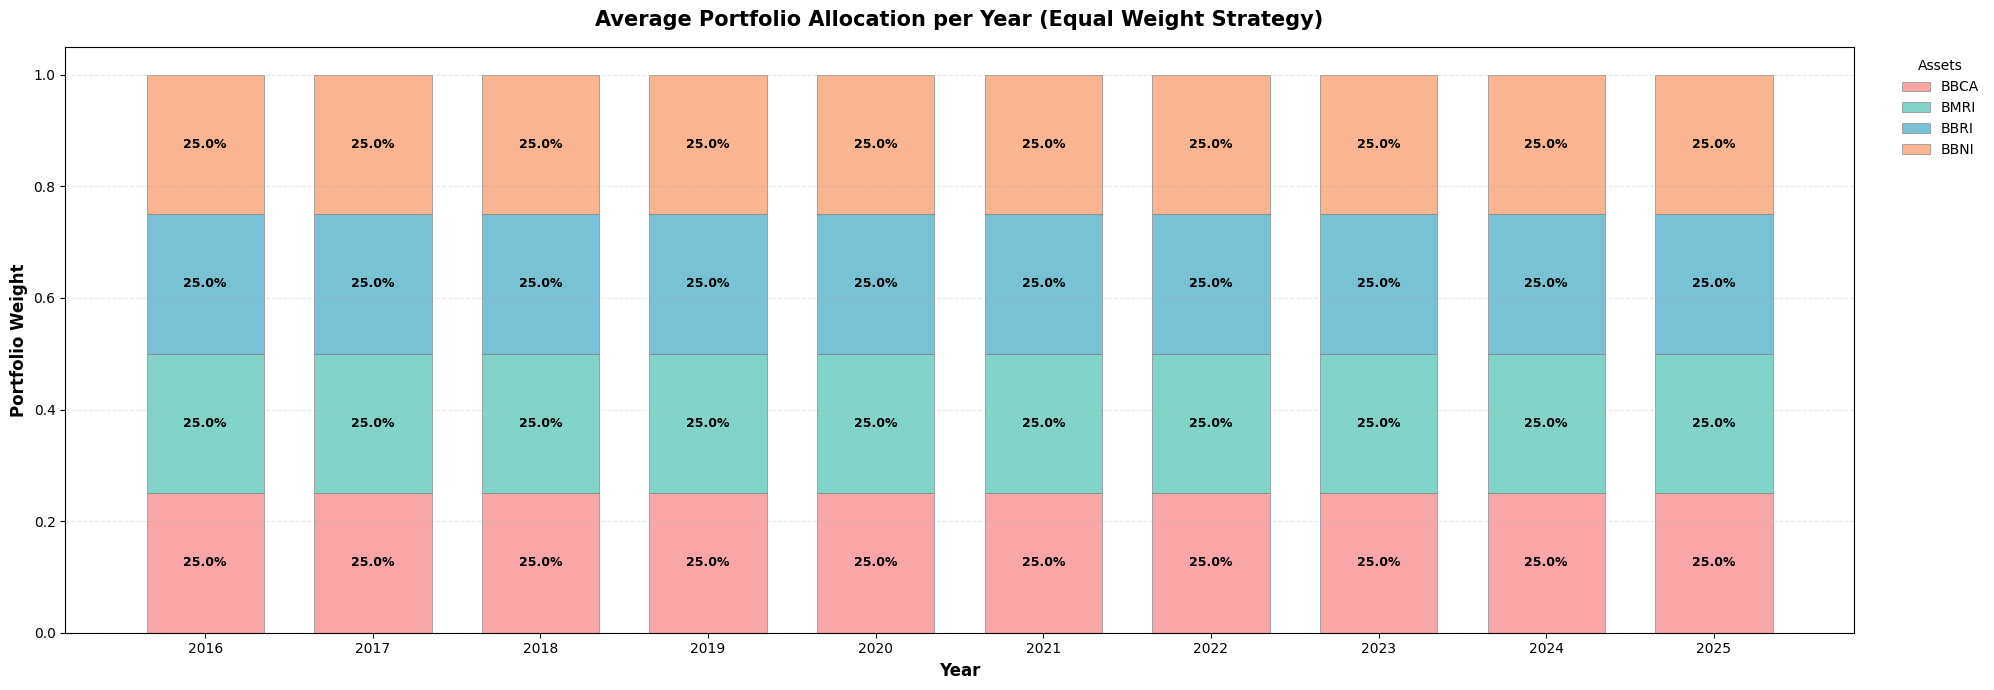

In [25]:
num_assets = len(TICKERS)
equal_weight = 1.0 / num_assets

ew_weights_data = {ticker.replace(".JK",""): [equal_weight] * len(years) for ticker in TICKERS}
yearly_ew_weights = pd.DataFrame(ew_weights_data, index=years)

fig, ax = plt.subplots(figsize=(20, 7), facecolor="white")
bottom = np.zeros(len(years))
colors_bar = ['#f99da0', '#73d0c1', '#6bbbd1', '#f9ac85']

for i, ticker in enumerate(TICKERS):
    ticker_name = ticker.replace(".JK","")
    values = yearly_ew_weights[ticker_name].values

    ax.bar(years, values, bottom=bottom, label=ticker_name, color=colors_bar[i], alpha=0.9, edgecolor="grey", linewidth=0.5, width=0.7)

    for j, val in enumerate(values):
        ax.text(years[j], bottom[j] + val/2, f"{val*100:.1f}%", ha="center", va="center", fontsize=9, fontweight="bold")

    bottom += values.astype(float)

ax.set_title("Average Portfolio Allocation per Year (Equal Weight Strategy)", fontsize=15, fontweight="bold", pad=15)
ax.set_xlabel("Year", fontsize=12, fontweight="bold")
ax.set_ylabel("Portfolio Weight", fontsize=12, fontweight="bold")
ax.set_ylim(0, 1.05)
ax.set_xticks(years)
ax.legend(title="Assets", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## **Annualized Return per Year**

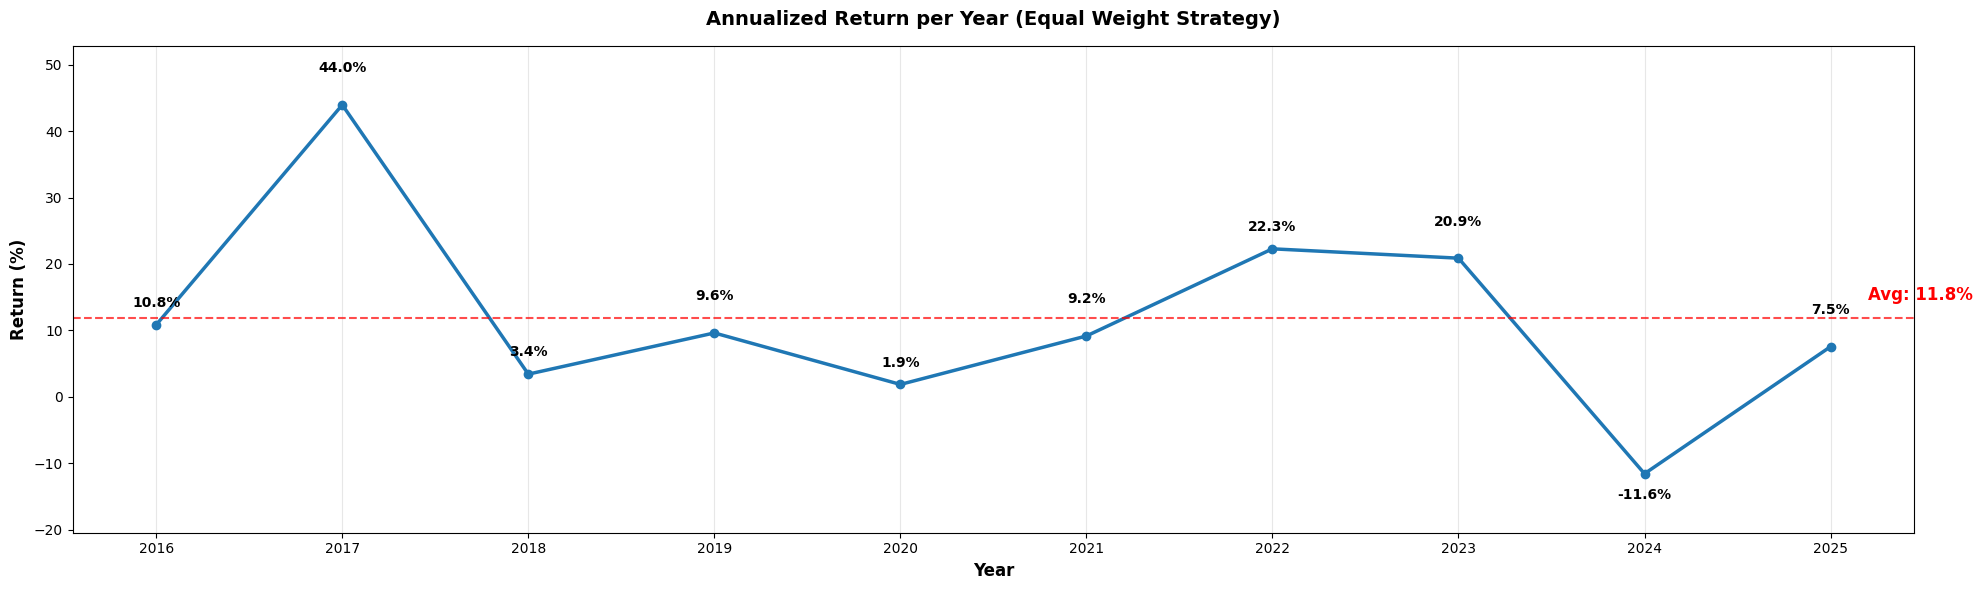

In [112]:
values_ew = yearly_ann_return["EqualWeight"] * 100
plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values_ew, marker="o", linewidth=2.5, color='#1f77b4', label="Equal Weight")
y_range_ew = values_ew.max() - values_ew.min()
offset_ew = y_range_ew * 0.04 if y_range_ew != 0 else 0.5

for i, (x, y) in enumerate(zip(years, values_ew)):
    va = "bottom" if y >= 0 else "top"
    shift = offset_ew if i % 2 == 0 else offset_ew * 2
    y_text = y + shift if y >= 0 else y - shift
    plt.text(x, y_text, f"{y:.1f}%", ha="center", va=va, fontsize=10, fontweight="bold")

avg_return_ew = values_ew.mean()
plt.axhline(avg_return_ew, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
plt.text(years[-1] + 0.2, avg_return_ew + offset_ew, f'Avg: {avg_return_ew:.1f}%', color='red', va='bottom', fontsize=12, fontweight="bold")
plt.title("Annualized Return per Year (Equal Weight Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Return (%)", fontsize=12, fontweight="bold")
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values_ew.min() - offset_ew * 4, values_ew.max() + offset_ew * 4)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## **Annualized Volatility per Year**

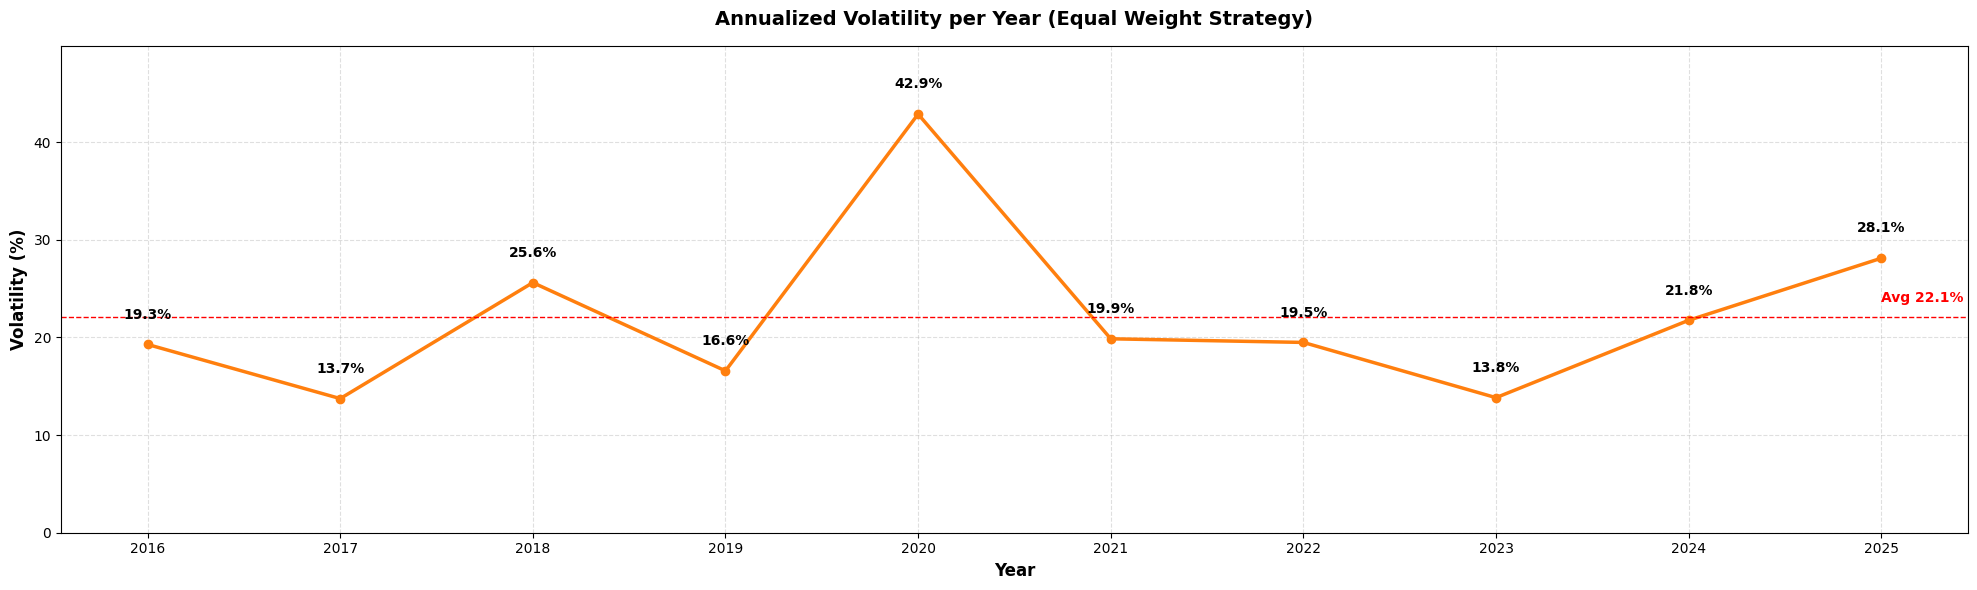

In [119]:
values_vol_ew = yearly_ann_vol["EqualWeight"] * 100
plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values_vol_ew, marker="o", linewidth=2.5, color="#ff7f0e", label="Equal Weight")
y_range_vol = values_vol_ew.max() - values_vol_ew.min()
offset_vol = y_range_vol * 0.08 if y_range_vol != 0 else 0.5

for x, y in zip(years, values_vol_ew):
    plt.text(x,y + offset_vol,f"{y:.1f}%",ha="center",va="bottom",fontsize=10,fontweight="bold")

avg_vol = values_vol_ew.mean()
avg_offset = y_range_vol * 0.04 if y_range_vol != 0 else 0.3
plt.axhline(avg_vol, linewidth=1, linestyle="--", color="red")
plt.text(years[-1],avg_vol + avg_offset,f"Avg {avg_vol:.1f}%",ha="left",va="bottom",fontsize=10,fontweight="bold",color="red")
plt.title("Annualized Volatility per Year (Equal Weight Strategy)",fontsize=14,fontweight="bold",pad=15)
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(0, values_vol_ew.max() + offset_vol * 3)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## **Annualized Sharpe Ratio**

0 = Break even

1 = Good

2 = Very Good

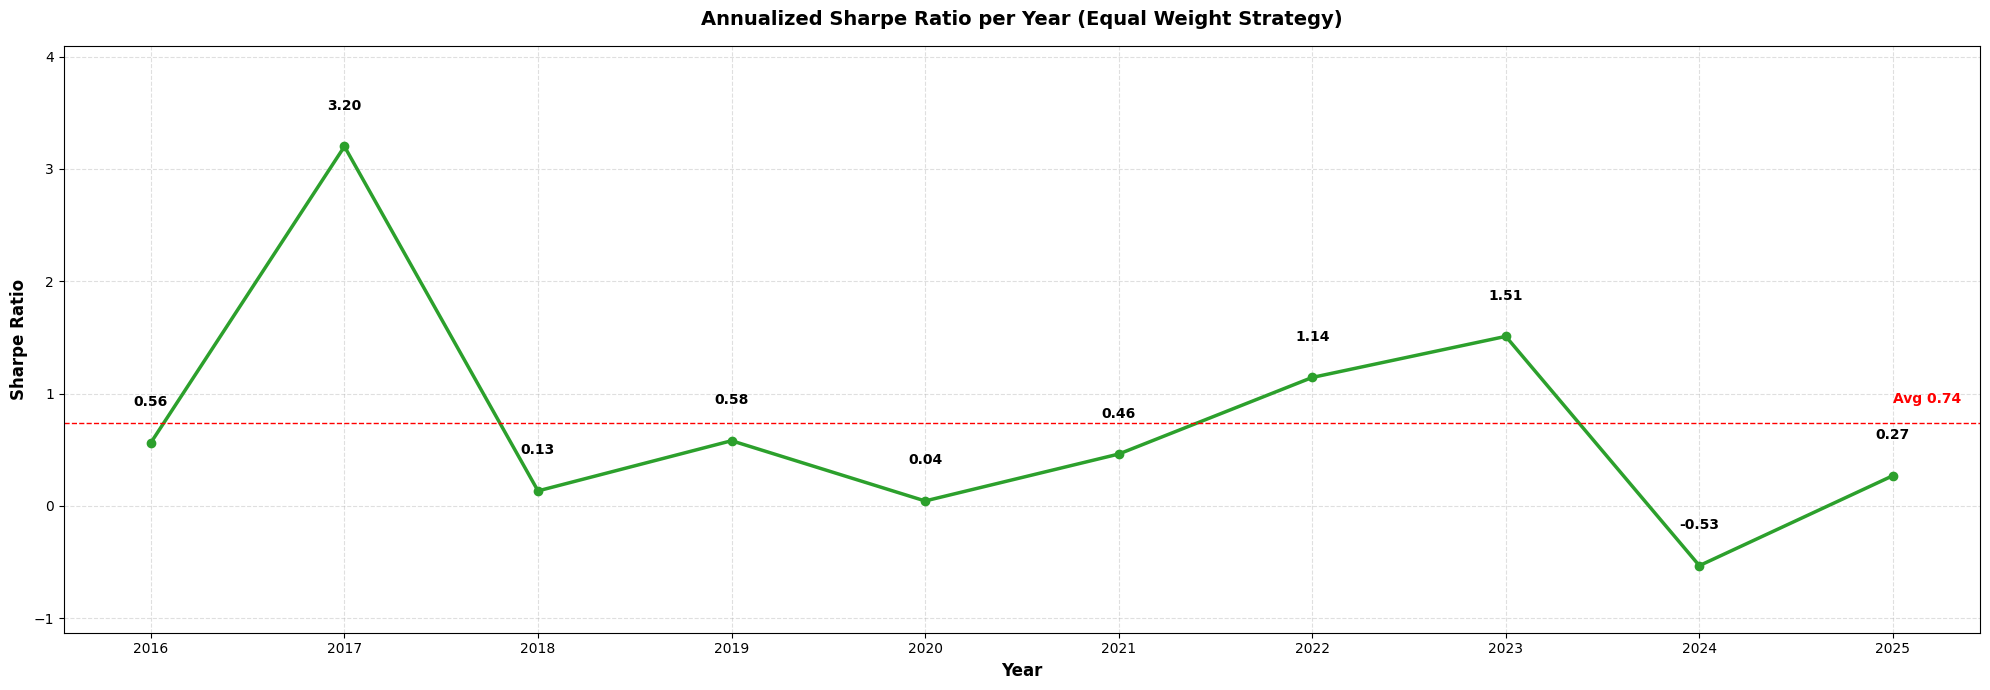

In [121]:
values_sharpe_ew = yearly_ann_sharpe["EqualWeight"]
plt.figure(figsize=(20, 7), facecolor="white")
plt.plot(years, values_sharpe_ew, marker="o", linewidth=2.5, color="#2ca02c", label="Equal Weight")
y_range_sharpe = values_sharpe_ew.max() - values_sharpe_ew.min()
offset_sharpe = y_range_sharpe * 0.08 if y_range_sharpe != 0 else 0.1

for x, y in zip(years, values_sharpe_ew):
    plt.text(x,y + offset_sharpe,f"{y:.2f}",ha="center",va="bottom",fontsize=10,fontweight="bold")

avg_sharpe = values_sharpe_ew.mean()
avg_offset = y_range_sharpe * 0.04 if y_range_sharpe != 0 else 0.05
plt.axhline(avg_sharpe, linewidth=1, linestyle="--", color="red")
plt.text(years[-1],avg_sharpe + avg_offset,f"Avg {avg_sharpe:.2f}",ha="left",va="bottom",fontsize=10,fontweight="bold",color="red")
plt.title("Annualized Sharpe Ratio per Year (Equal Weight Strategy)",fontsize=14,fontweight="bold",pad=15)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values_sharpe_ew.min() - offset_sharpe * 2,values_sharpe_ew.max() + offset_sharpe * 3)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# **Result Mean Variance Strategy**

## **Portfolio Allocation per Year**

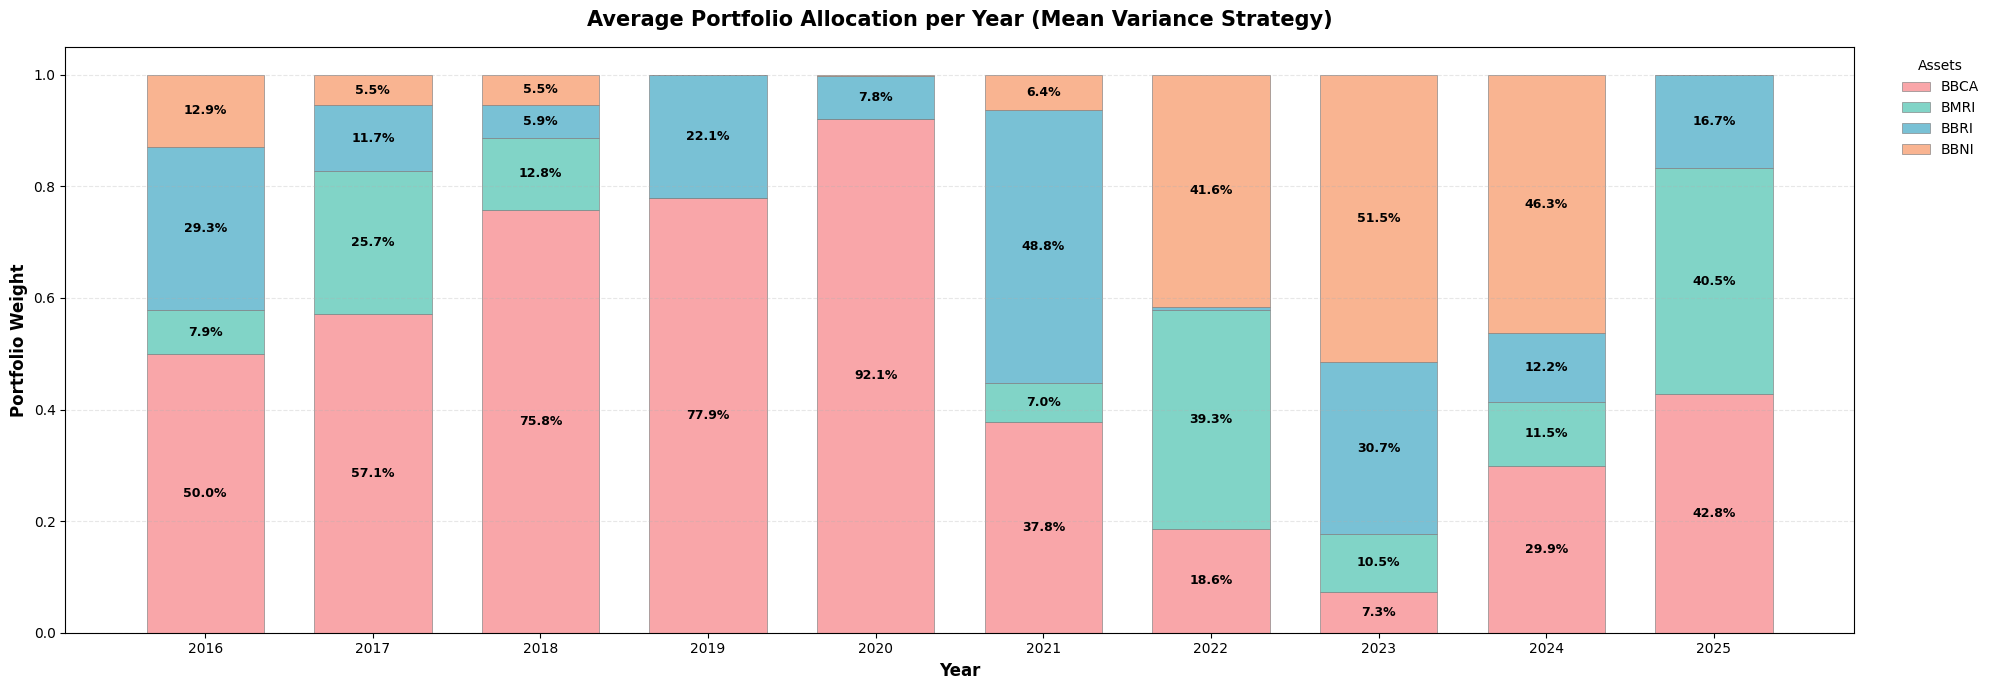

In [29]:
mv_weights_df = pd.DataFrame(mv_weights_history, index=dates_history, columns=[t.replace(".JK","") for t in TICKERS])
yearly_mv_weights = mv_weights_df.groupby(mv_weights_df.index.year).mean()

fig, ax = plt.subplots(figsize=(20, 7), facecolor="white")
years = yearly_mv_weights.index
bottom = np.zeros(len(years))
colors_bar = ['#f99da0', '#73d0c1', '#6bbbd1', '#f9ac85']

for i, ticker in enumerate(TICKERS):
    values = yearly_mv_weights[ticker.replace(".JK","")].values
    ax.bar(years, values, bottom=bottom, label=ticker.replace(".JK",""), color=colors_bar[i], alpha=0.9, edgecolor="grey", linewidth=0.5, width=0.7)
    for j, val in enumerate(values):
        if val > 0.05:
            ax.text(years[j], bottom[j] + val/2, f"{val*100:.1f}%", ha="center", va="center", fontsize=9, fontweight="bold")
    bottom += values.astype(float)

ax.set_title("Average Portfolio Allocation per Year (Mean Variance Strategy)", fontsize=15, fontweight="bold", pad=15)
ax.set_xlabel("Year", fontsize=12, fontweight="bold")
ax.set_ylabel("Portfolio Weight", fontsize=12, fontweight="bold")
ax.set_ylim(0,1.05)
ax.set_xticks(years)
ax.legend(title="Assets", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## **Annualized Return per Year**

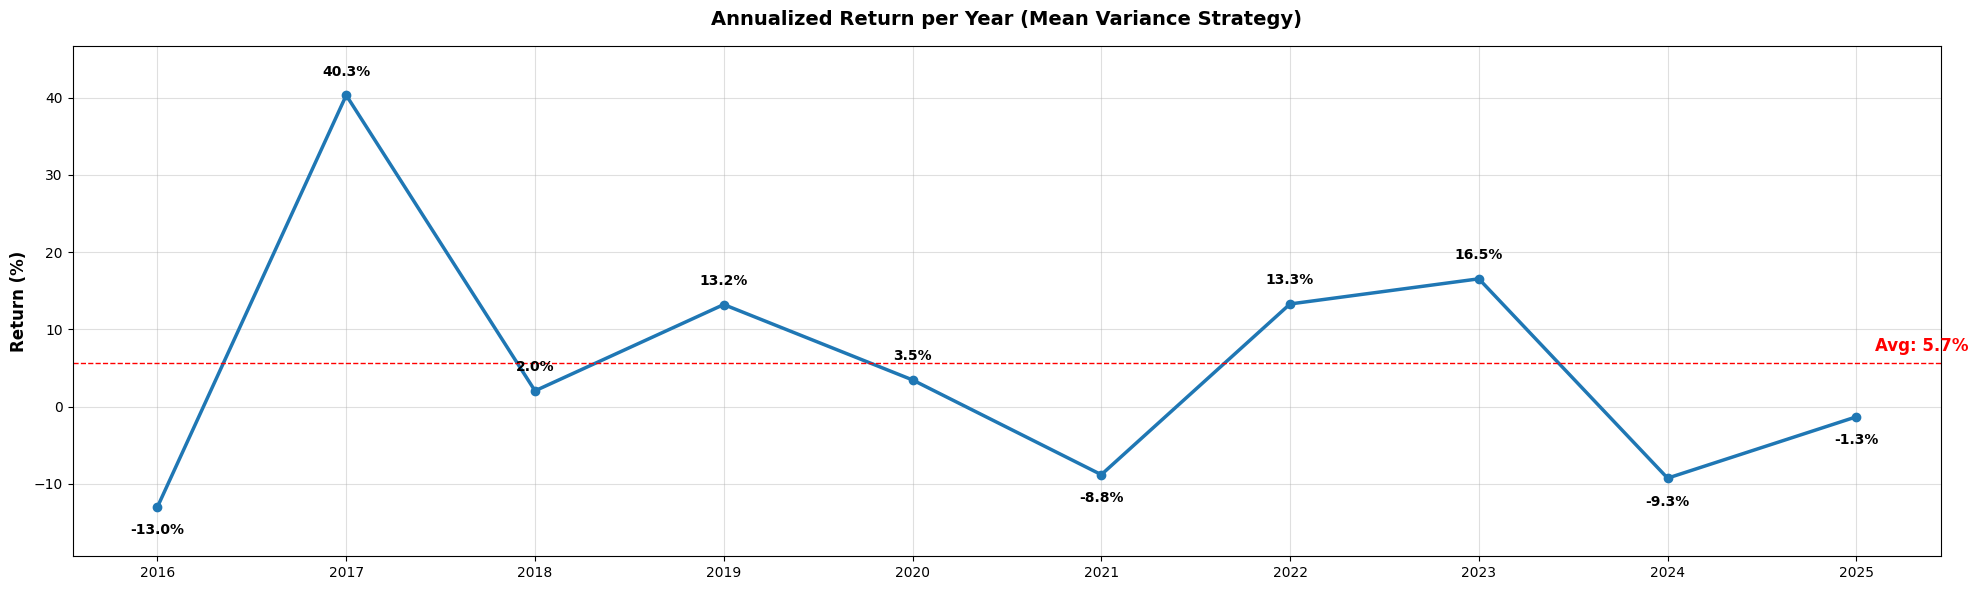

In [54]:
daily_rets_sim = results_df.pct_change().dropna()
yearly_ann_return = daily_rets_sim.groupby(daily_rets_sim.index.year).mean() * 252
yearly_ann_vol = daily_rets_sim.groupby(daily_rets_sim.index.year).std() * np.sqrt(252)
yearly_ann_sharpe = yearly_ann_return / yearly_ann_vol
years = yearly_ann_return.index
values = yearly_ann_return["MeanVariance"] * 100
plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#1f77b4')
y_range = values.max() - values.min()
offset = y_range * 0.04 if y_range != 0 else 0.5

for x, y in zip(years, values):
    va = "bottom" if y >= 0 else "top"
    y_text = y + offset if y >= 0 else y - offset
    plt.text(x, y_text, f"{y:.1f}%", ha="center", va=va, fontsize=10, fontweight="bold")

avg_return = values.mean()
plt.axhline(avg_return, color='red', linestyle='--', linewidth=1)
offset_label = y_range * 0.02
plt.text(years[-1] + 0.1, avg_return + offset_label, f'Avg: {avg_return:.1f}%', color='red', va='bottom', fontsize=12, fontweight="bold")
plt.title("Annualized Return per Year (Mean Variance Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Return (%)", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values.min() - offset * 3, values.max() + offset * 3)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

## **Annualized Volatility per Year**

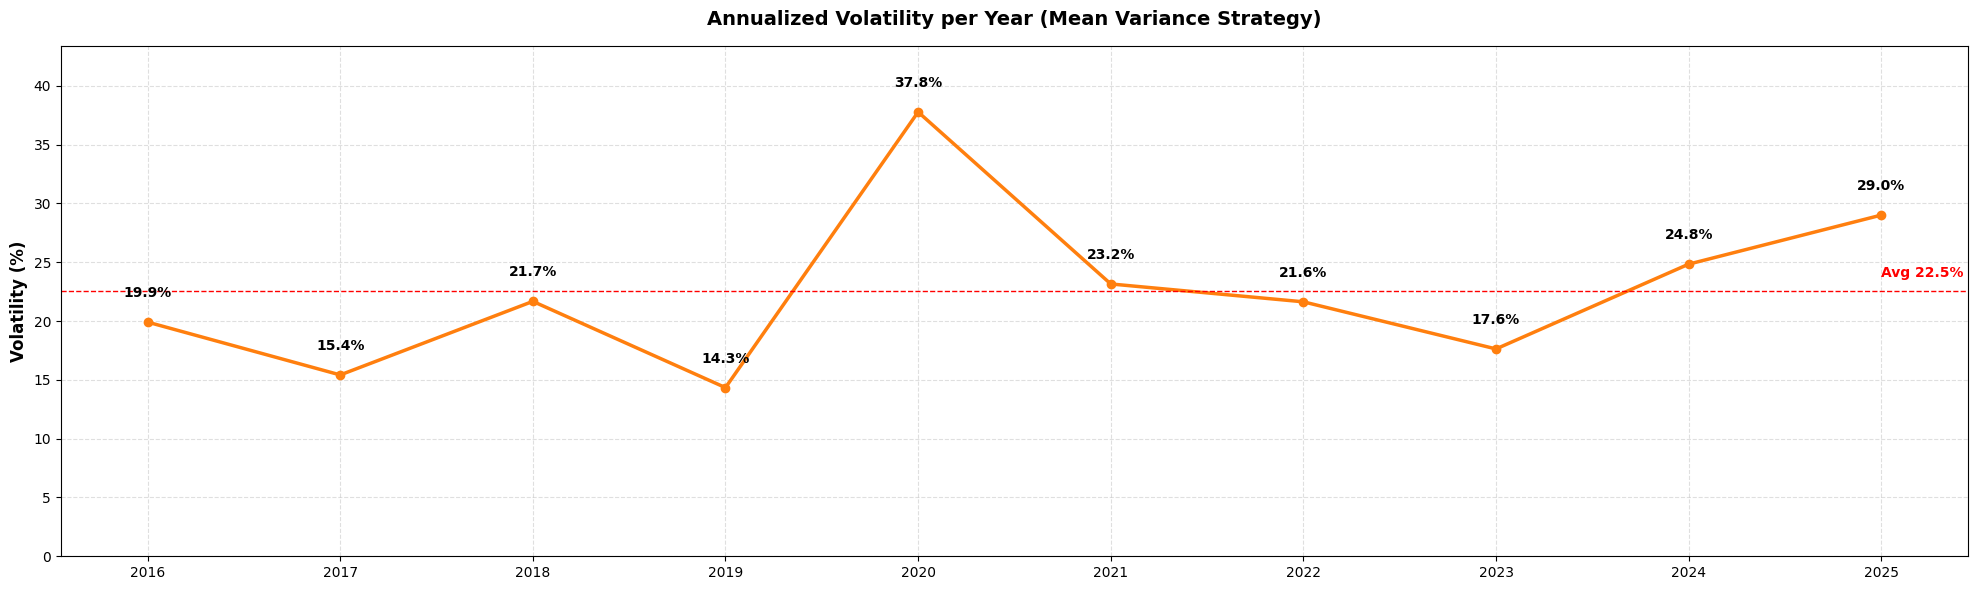

In [124]:
values = yearly_ann_vol["MeanVariance"] * 100
plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color="#ff7f0e")
y_range = values.max() - values.min()
offset = y_range * 0.08 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x,y + offset,f"{y:.1f}%",ha="center",va="bottom",fontsize=10,fontweight="bold")

avg_val = values.mean()
avg_offset = y_range * 0.04 if y_range != 0 else 0.05
plt.axhline(avg_val, linewidth=1, linestyle="--", color="red")
plt.text(years[-1],avg_val + avg_offset,f"Avg {avg_val:.1f}%",ha="left",va="bottom",fontsize=10,fontweight="bold",color="red")
plt.title("Annualized Volatility per Year (Mean Variance Strategy)",fontsize=14,fontweight="bold",pad=15)
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(0, values.max() + offset * 3)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## **Annualized Sharpe Ratio**

0 = Break even

1 = Good

2 = Very Good

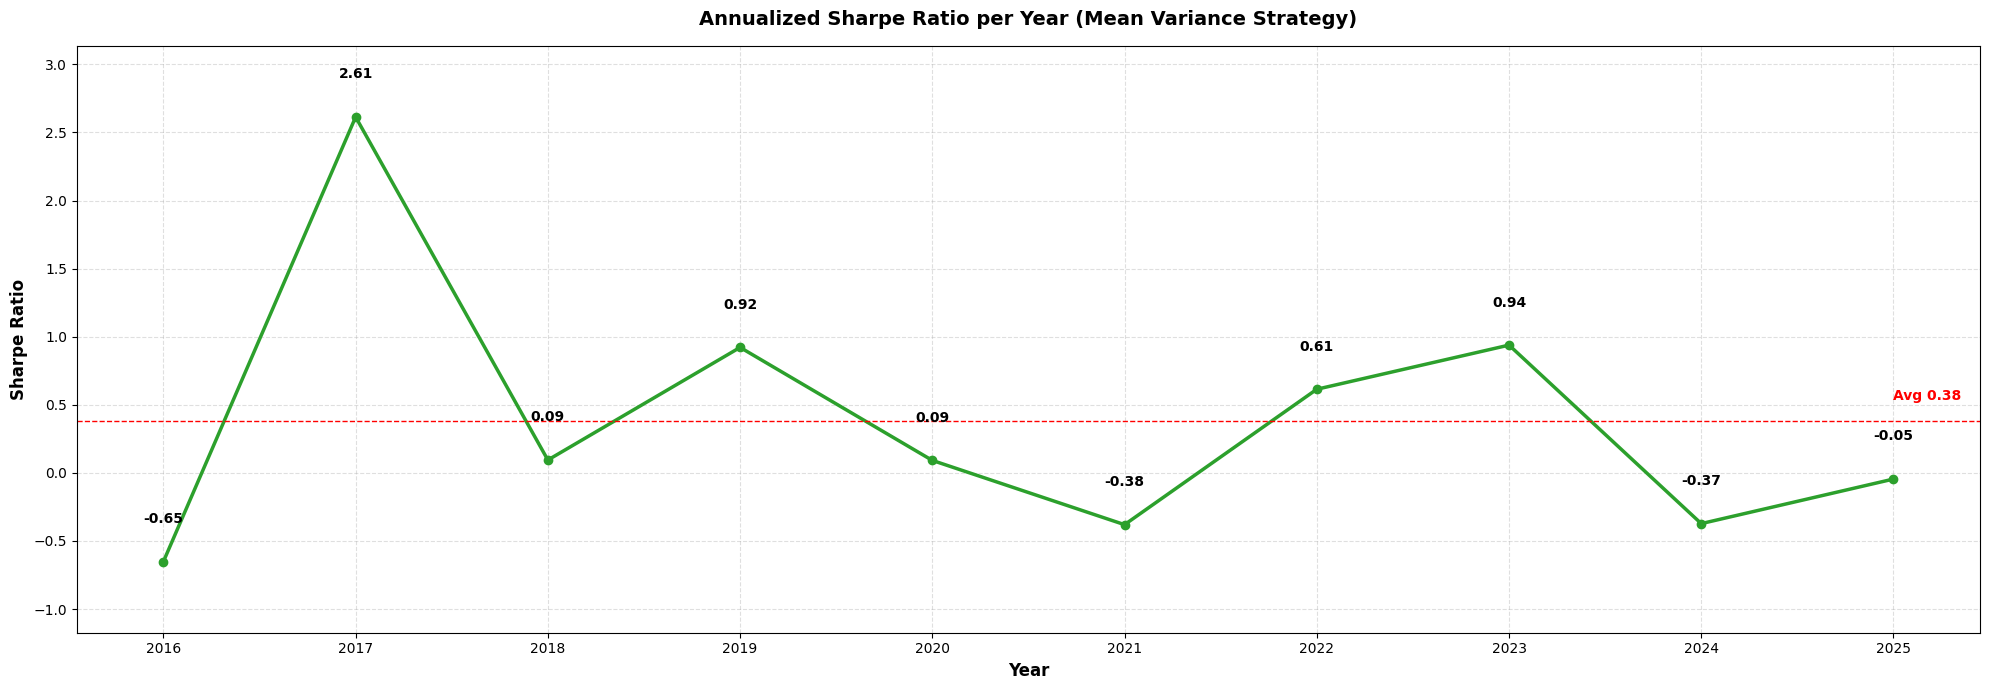

In [126]:
values = yearly_ann_sharpe["MeanVariance"]
plt.figure(figsize=(20, 7), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color="#2ca02c")
y_range = values.max() - values.min()
offset = y_range * 0.08 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x,y + offset,f"{y:.2f}",ha="center",va="bottom",fontsize=10,fontweight="bold")

avg_val = values.mean()
avg_offset = y_range * 0.04 if y_range != 0 else 0.05
plt.axhline(avg_val, linewidth=1, linestyle="--", color="red")
plt.text(years[-1],avg_val + avg_offset,f"Avg {avg_val:.2f}", ha="left",va="bottom",fontsize=10,fontweight="bold",color="red")
plt.title("Annualized Sharpe Ratio per Year (Mean Variance Strategy)",fontsize=14,fontweight="bold",pad=15)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(values.min() - offset * 2, values.max() + offset * 2)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# **Portfolio Allocation 2026**

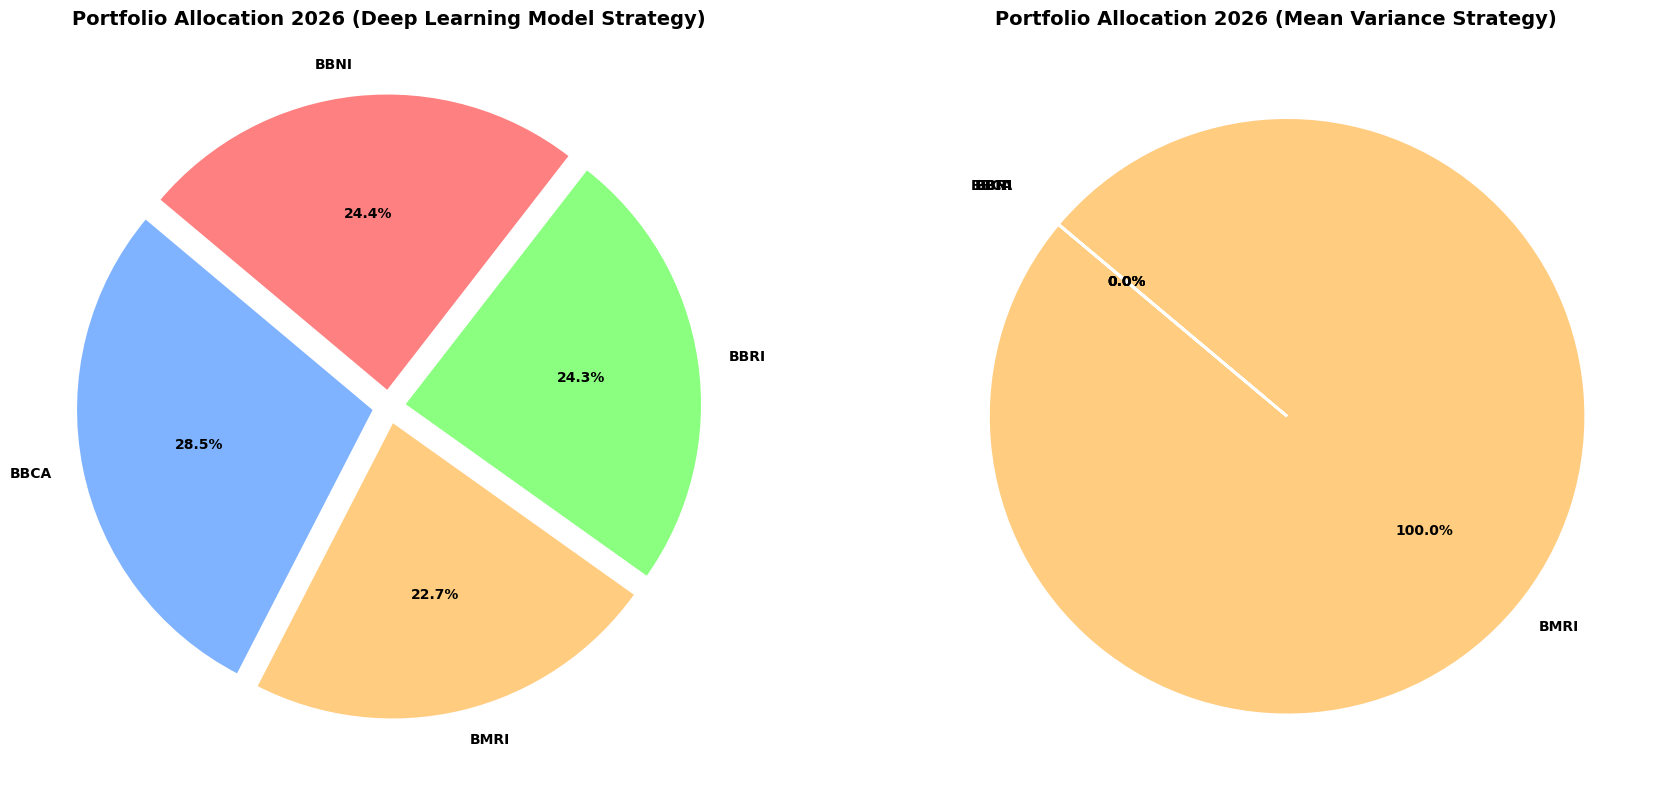

In [127]:
last_features = X_raw.tail(LOOKBACK_WINDOW)
mean_recent = X_raw.tail(ROLLING_SCALER_DAYS).mean()
std_recent = X_raw.tail(ROLLING_SCALER_DAYS).std()
last_features_scaled = (last_features - mean_recent) / (std_recent + 1e-8)
input_dl = last_features_scaled.values.reshape(1, LOOKBACK_WINDOW, -1)
dl_weights = model.predict(input_dl, verbose=0)[0]
dl_weights = np.clip(dl_weights, 0, 1)
dl_weights /= dl_weights.sum()
recent_asset_returns = y_raw.tail(252)
mu_assets = recent_asset_returns.mean() * 252
sigma_assets = recent_asset_returns.cov() * 252

def neg_sharpe(w):
    r = np.dot(mu_assets, w)
    v = np.sqrt(w.T @ sigma_assets @ w) + 1e-8
    return -r / v

constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(len(TICKERS)))
init_w = np.ones(len(TICKERS)) / len(TICKERS)
mvo_weights = minimize(neg_sharpe, init_w, method='SLSQP', bounds=bounds, constraints=constraints).x
labels = [t.replace('.JK', '') for t in TICKERS]
colors = ['#80b3ff', '#ffcc80', '#8aff80', '#ff8080']
explode = [0.05]*len(TICKERS)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), facecolor="white")

def make_autopct(pct):
    return f'{pct:.1f}%'

ax1.pie(dl_weights, labels=labels, autopct=lambda pct: f'{pct:.1f}%', startangle=140, colors=colors, explode=explode, wedgeprops={'edgecolor': 'white', 'linewidth': 2}, textprops={'weight': 'bold'})
ax1.set_title("Portfolio Allocation 2026 (Deep Learning Model Strategy)", fontsize=14, fontweight='bold')
ax2.pie(mvo_weights, labels=labels, autopct=lambda pct: f'{pct:.1f}%', startangle=140,colors=colors, explode=explode, wedgeprops={'edgecolor': 'white', 'linewidth': 2}, textprops={'weight': 'bold'})
ax2.set_title("Portfolio Allocation 2026 (Mean Variance Strategy)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# **Annual Portfolio Return Expectations**

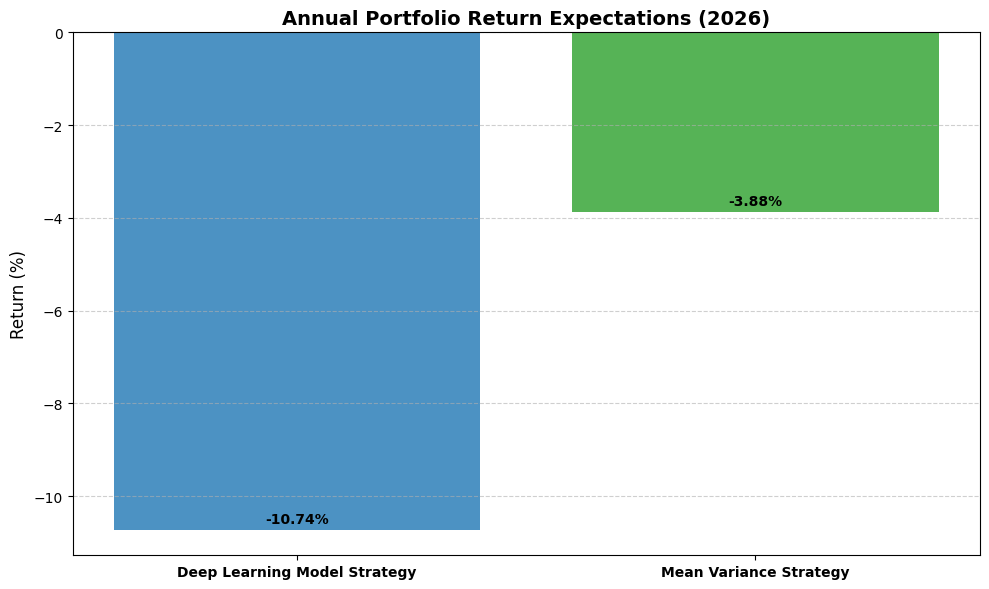

In [128]:
expected_return_dl = np.dot(dl_weights, mu_assets)
expected_return_mvo = np.dot(mvo_weights, mu_assets)
models = ['Deep Learning Model Strategy', 'Mean Variance Strategy']
returns = [expected_return_dl * 100, expected_return_mvo * 100]
plt.figure(figsize=(10, 6), facecolor="white")
bars = plt.bar(models, returns, color=['#1f77b4', '#2ca02c'], alpha=0.8)
plt.title("Annual Portfolio Return Expectations (2026)", fontsize=14, fontweight='bold')
plt.ylabel("Return (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar, ret in zip(bars, returns):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1,f'{ret:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.xticks(fontweight='bold')
plt.tight_layout()
plt.show()